In [42]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

## Get feature types

In [43]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [44]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [45]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [46]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [47]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [48]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 25
num_folds=3

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [49]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [50]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_2 = 15
num_folds=3

def cnn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = cnn_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.Adam()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_2, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_2, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

In [51]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 20

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Original Data from NHANES

In [52]:
df_raw_mlp =  pd.read_csv('df_progressive_mlp_2.csv')  # 53 columns
df_raw_mlp.head()

,SEQN,year,depressed,race_ethnicity,edu_level,#_ppl_household,age,gender,marital_status,annual_HI,...,systolic_BP,diastolic_BP,BMI,waist_C,#meals_fast_food,min_sedetary,doc_HPV,bone_mineral_density,difficult_hearing,doc_COPD
0,31131.0,2005-2006,0.0,4.0,4.0,4.0,44.0,2.0,1.0,11.0,...,144.0,74.0,30.90,96.0,1.794356,25.937662,0.0,0.841958,0.0,0.0
1,31132.0,2005-2006,0.0,3.0,5.0,2.0,70.0,1.0,1.0,11.0,...,138.0,60.0,24.74,96.5,0.953694,25.937662,0.0,0.841958,0.0,0.0
2,31134.0,2005-2006,0.0,3.0,3.0,2.0,73.0,1.0,1.0,11.0,...,130.0,68.0,30.63,117.1,0.953694,25.937662,0.0,0.841958,0.0,0.0
3,31139.0,2005-2006,0.0,2.0,4.0,3.0,18.0,2.0,5.0,11.0,...,110.0,64.0,29.45,84.0,2.181368,25.937662,0.0,0.841958,0.0,0.0
4,31143.0,2005-2006,0.0,3.0,4.0,3.0,19.0,1.0,5.0,11.0,...,108.0,62.0,22.57,84.2,3.324394,25.937662,0.0,0.841958,0.0,0.0


Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               16000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________

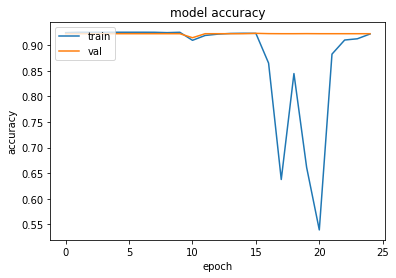

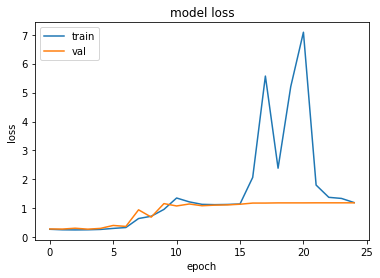

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
nn_kfold(df_raw_mlp)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 78, 32)            128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 77, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 76, 64)            4160      
______________

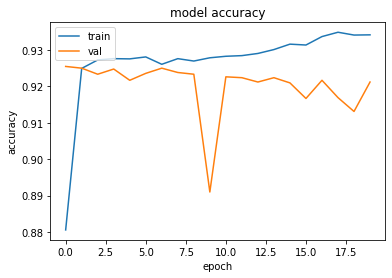

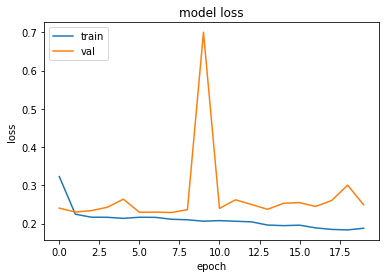

[[9443  138]
 [ 669   98]]
F1 score: 0.1954137587238285
Precision: 0.4152542372881356
Recall: 0.12777053455019557
Accuracy: 0.9220139157325087
ROC AUC: 0.5566835138046876


In [36]:
cnn(df_raw_mlp)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 200)               16000     
_________________________________________________________________
dropout_172 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_173 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_174 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 196us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8173922343916609;  accuracy of 0.7536770105361938; precision of 0.7536770105361938; recall of 0.7536770105361938; AUC of 0.8203524351119995;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 179us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.152504034507416;  accuracy of 0.6809938549995422; precision of 0.6809938549995422; recall of 0.6809938549995422; AUC of 0.7461614012718201;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 202us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.1124364343963487;  accuracy of 0.7029844522476196; precision of 0.7029844522476196; recall of 0.7029844522476196; AUC of 0.754606306552887;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


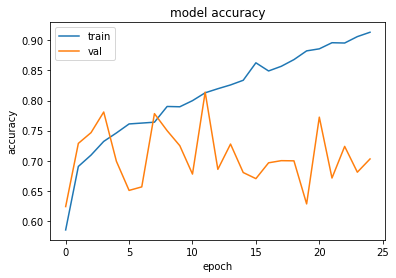

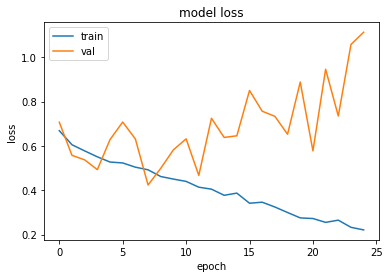

[[6562 3019]
 [ 270  497]]
F1 score: 0.23208031753443847
Precision: 0.141353811149033
Recall: 0.6479791395045632
Accuracy: 0.6821608040201005
ROC AUC: 0.6664381659322212


In [37]:
nn_kfold(df_raw_mlp, balanced_batches=True)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 78, 32)            128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 77, 32)            128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 76, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


4202/4202 [==============================] - 11s 3ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.826098000702547;  accuracy of 0.6891956329345703; precision of 0.6891956329345703; recall of 0.6891956329345703; AUC of 0.7478829026222229;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


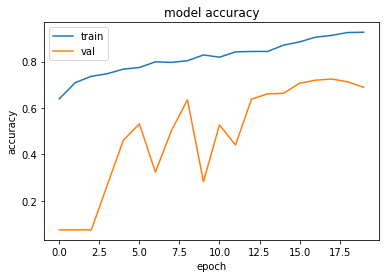

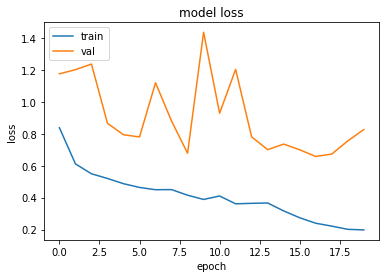

[[6666 2915]
 [ 279  488]]
F1 score: 0.23405275779376497
Precision: 0.14340287981193064
Recall: 0.636245110821382
Accuracy: 0.6913413219945883
ROC AUC: 0.6659985600031135


In [53]:
cnn(df_raw_mlp, balanced_batches=True)

## Data with more features from NHANES

In [54]:
# read in normal MLP imputed more features data
df_raw_mlp_OG =  pd.read_csv('df_progressive_mlp_ext_ext.csv')  # 112 columns
df_raw_mlp_OG.head()


,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium,serum_zinc,serum_creatinine,lab_VitB12,bone_mineral_density,difficult_hearing,difficult_seeing,difficult_walking,difficult_errands,doc_COPD
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,112.165861,70.651824,3.009842,445.315137,0.66774,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,130.388149,78.349765,3.009842,617.933179,0.66774,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,122.699054,76.363158,3.009842,364.136623,0.66774,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,124.657159,80.049287,3.009842,638.522461,0.66774,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,116.930334,73.545760,3.009842,511.363360,0.66774,0.0,0.0,0.0,0.0,0.0


Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               33400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

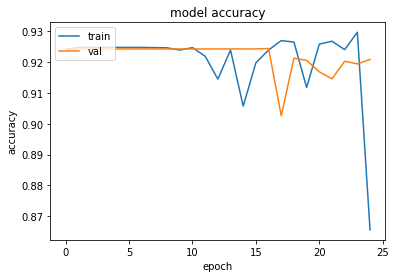

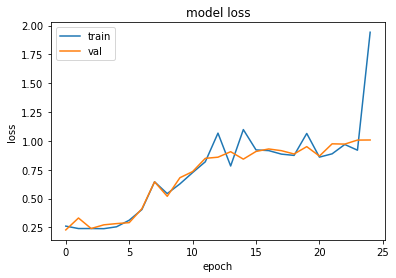

[[9433  148]
 [ 672   95]]
F1 score: 0.1881188118811881
Precision: 0.39094650205761317
Recall: 0.12385919165580182
Accuracy: 0.9207576343254735
ROC AUC: 0.5542059761639828


In [20]:
nn_kfold(df_raw_mlp_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 165, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 164, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 163, 64)           4160      
___________

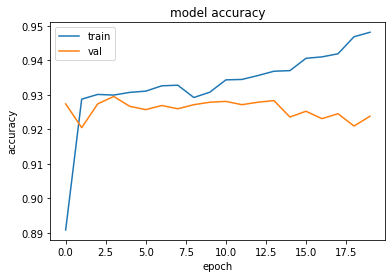

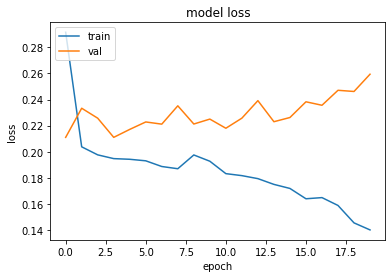

[[9366  215]
 [ 589  178]]
F1 score: 0.306896551724138
Precision: 0.4529262086513995
Recall: 0.2320730117340287
Accuracy: 0.9223038268264399
ROC AUC: 0.6048163827065927


In [16]:
cnn(df_raw_mlp_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 200)               33400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_59 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_60 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 178us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.819214887828737;  accuracy of 0.7035556435585022; precision of 0.7035556435585022; recall of 0.7035556435585022; AUC of 0.7192448377609253;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 188us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.8399652710952334;  accuracy of 0.7332571744918823; precision of 0.7332571744918823; recall of 0.7332571744918823; AUC of 0.7918371558189392;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 222us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.7237184842143862;  accuracy of 0.7455376386642456; precision of 0.7455376386642456; recall of 0.7455376386642456; AUC of 0.8080606460571289;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


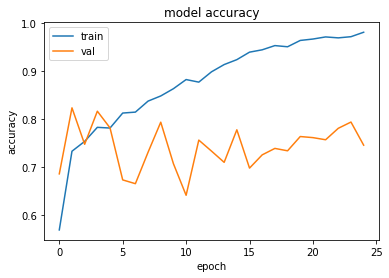

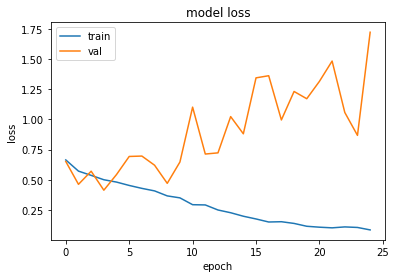

[[7060 2521]
 [ 246  521]]
F1 score: 0.2735626148595432
Precision: 0.1712689020381328
Recall: 0.6792698826597132
Accuracy: 0.7326053343641283
ROC AUC: 0.7080724739464936


In [28]:
nn_kfold(df_raw_mlp_OG, balanced_batches=True)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 165, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 163, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 51s 643ms/step - loss: 0.6772 - accuracy: 0.7124 - precision: 0.7124 - recall: 0.7124 - AUC: 0.7742 - val_loss: 0.8965 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1191
Epoch 2/20
79/79 [==============================] - 32s 411ms/step - loss: 0.5080 - accuracy: 0.7572 - precision: 0.7572 - recall: 0.7572 - AUC: 0.8386 - val_loss: 0.9941 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1172
Epoch 3/20
79/79 [==============================] - 32s 408ms/step - loss: 0.4546 - accuracy: 0.7815 - precision: 0.7815 - recall: 0.7815 - AUC: 0.8674 - val_loss: 1.2680 - val_accuracy: 0.0764 - val_precision: 0.0764 - val_recall: 0.0764 - val_AUC: 0.1154
Epoch 4/20
79/79 [==============================] - 32s 405ms/step - loss: 0.4224 - accuracy: 0.8035 - precision: 0.8035 - recall: 0.8035 - AUC: 0.8870 - val_loss: 0.7767 - val_accuracy: 0.4595 - val_precision: 0.4595 - val_recal

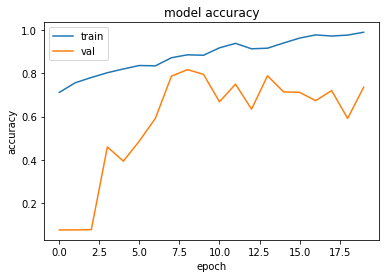

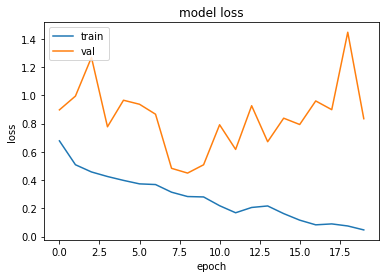

[[7033 2548]
 [ 250  517]]
F1 score: 0.2698329853862213
Precision: 0.16867862969004893
Recall: 0.6740547588005215
Accuracy: 0.729609586393506
ROC AUC: 0.7040558732944263


In [55]:
cnn(df_raw_mlp_OG, balanced_batches=True)

## Subset of NHANES features 1/3

In [13]:
subset1 = ['depressed','tried_lose_weight', 'triglyceride', 'tot_cholesterol', 'glycohemoglobin', 
           'herpes_2', 'HIV', 'rbc_folate', 'serum_folate', 'fasting_glucose', 'lab_VitD', 
           'systolic_BP', 'diastolic_BP', 'pulse', 'BMI', 'waist_C', 'VitD', '#meals_fast_food', 
           'monthly_income', 'savings_5000', 'min_sedetary', 'doc_HPV', 'oral_rec', 
           'difficult_remembering', 'prob_smell', 'prob_tatse', 'persistent_cold', 
           'nasal_congestion', 'serum_selenium', 'serum_zinc', 'serum_creatinine', 
           'lab_VitB12', 'bone_mineral_density', 'difficult_hearing', 'difficult_seeing', 
           'difficult_walking', 'difficult_errands']

df_mlp_sub1 = df_raw_mlp_OG[subset1]


Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_245 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_246 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_247 (Dropout)        (None, 100)               0         
______________

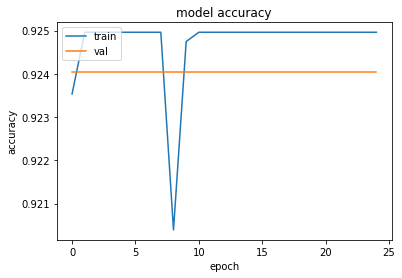

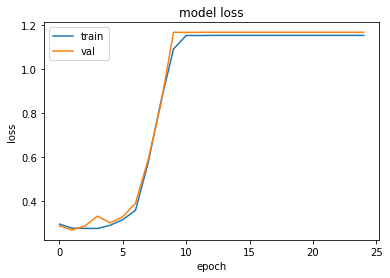

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
nn_kfold(df_mlp_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 39, 1)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 32)            96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 38, 32)            128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 37, 32)            2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 37, 32)            128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 36, 64)            4160      
______________

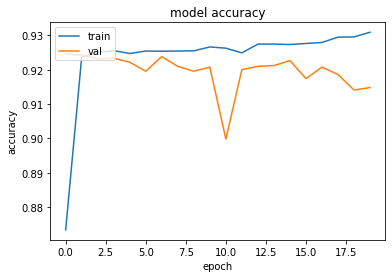

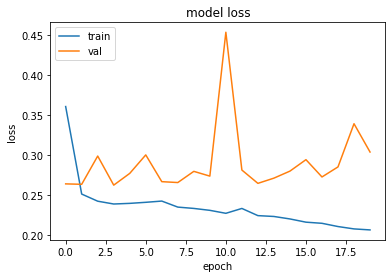

[[9453  128]
 [ 710   57]]
F1 score: 0.11974789915966386
Precision: 0.3081081081081081
Recall: 0.07431551499348109
Accuracy: 0.9190181677618864
ROC AUC: 0.5304778702198384


In [46]:
cnn(df_mlp_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_308 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_270 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_271 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_310 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_272 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 264us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8001797895984413;  accuracy of 0.617592453956604; precision of 0.617592453956604; recall of 0.617592453956604; AUC of 0.6880192756652832;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 252us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.7134835742702318;  accuracy of 0.600456953048706; precision of 0.600456953048706; recall of 0.600456953048706; AUC of 0.7085743546485901;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 245us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.7186488023863747;  accuracy of 0.5907468199729919; precision of 0.5907468199729919; recall of 0.5907468199729919; AUC of 0.6570233702659607;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


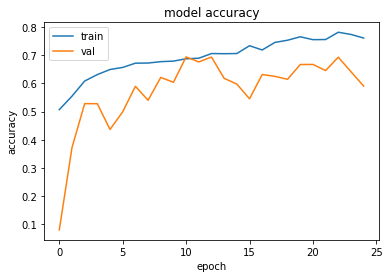

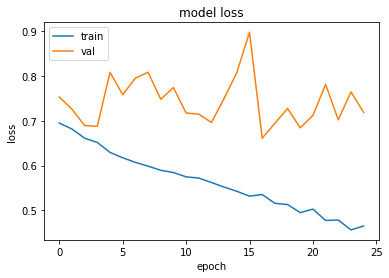

[[5642 3939]
 [ 265  502]]
F1 score: 0.19278033794162827
Precision: 0.11303760414321098
Recall: 0.6544980443285529
Accuracy: 0.5937379203710862
ROC AUC: 0.6216859285414813


In [47]:
nn_kfold(df_mlp_sub1, balanced_batches=True)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 39, 1)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 38, 32)            96        
_________________________________________________________________
batch_normalization_46 (Batc (None, 38, 32)            128       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 37, 32)            2080      
_________________________________________________________________
batch_normalization_47 (Batc (None, 37, 32)            128       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 36, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 23s 295ms/step - loss: 0.8522 - accuracy: 0.6036 - precision: 0.6036 - recall: 0.6036 - AUC: 0.6405 - val_loss: 1.1040 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.0912
Epoch 2/20
79/79 [==============================] - 12s 153ms/step - loss: 0.6728 - accuracy: 0.6438 - precision: 0.6438 - recall: 0.6438 - AUC: 0.7043 - val_loss: 1.0318 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.0927
Epoch 3/20
79/79 [==============================] - 10s 132ms/step - loss: 0.6241 - accuracy: 0.6761 - precision: 0.6761 - recall: 0.6761 - AUC: 0.7388 - val_loss: 1.0693 - val_accuracy: 0.0845 - val_precision: 0.0845 - val_recall: 0.0845 - val_AUC: 0.1025
Epoch 4/20
79/79 [==============================] - 9s 117ms/step - loss: 0.5526 - accuracy: 0.7228 - precision: 0.7228 - recall: 0.7228 - AUC: 0.7940 - val_loss: 0.9390 - val_accuracy: 0.2527 - val_precision: 0.2527 - val_recall

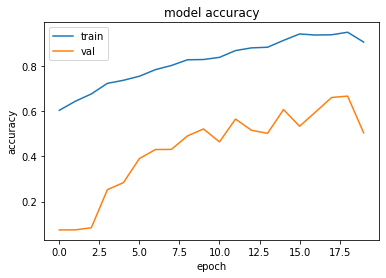

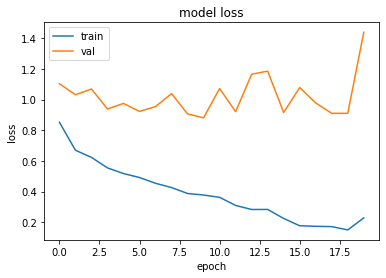

[[4754 4827]
 [ 242  525]]
F1 score: 0.17159666612191535
Precision: 0.09809417040358745
Recall: 0.6844850065189049
Accuracy: 0.5101468882875918
ROC AUC: 0.5903376916531484


In [56]:
cnn(df_mlp_sub1, balanced_batches=True)

## Subset intuitively chosen 1/2

In [14]:
subset2 = ['depressed', 'race_ethnicity', 'edu_level', 'age', 'gender', 'annual_HI',
              'marital_status', 'special_diet', 'protein', 'carb','sugar', 'fiber', 'fat', 
               'diet_chol', 'VitB6', 'folate', 'VitB12', 'doc_diabetes','how_healthy_diet', 
               'used_CMH', 'gen_health_cond','healthcare_past_yr', 'run_out_food', 'afford_balanced_meals',
              'food_security_cat', 'food_stamps', 'doc_asthma','doc_overweight', 'doc_arthritis', 
               'doc_CHD','doc_heart_attack', 'doc_stroke', 'doc_chronic_bronchitis',
               'doc_liver_condition', 'doc_thyroid_problem', 'doc_cancer','anemia', 'doc_kidney',
               'work_type', 'embarassed_mouth', 'lab_B12', 'vigorous_activity','moderate_activity', 
               'hours_TV', 'hours_computer','manage_$_difficult', 'doc_sleeping_disorder','hrs_sleep',
              'smoked_5days', 'sexual_orientation','alcoholic', 'consider_weight','triglyceride', 'tot_cholesterol',
              'rbc_folate','fasting_glucose', 'lab_VitD','BMI','min_sedetary','difficult_remembering',
              'persistent_cold','lab_VitB12','difficult_errands', 'doc_COPD']

df_mlp_sub2 = df_raw_mlp_OG[subset2]

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_294 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_295 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_296 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 249us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.116379875226411;  accuracy of 0.7501071095466614; precision of 0.7501071095466614; recall of 0.7501071095466614; AUC of 0.8254075646400452;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 273us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0326356680992754;  accuracy of 0.7488219141960144; precision of 0.7488219141960144; recall of 0.7488219141960144; AUC of 0.8058266043663025;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 257us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.8850738698544545;  accuracy of 0.6825646162033081; precision of 0.6825646162033081; recall of 0.6825646162033081; AUC of 0.7249933481216431;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


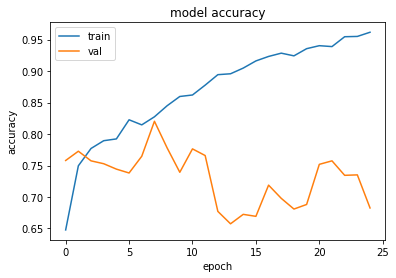

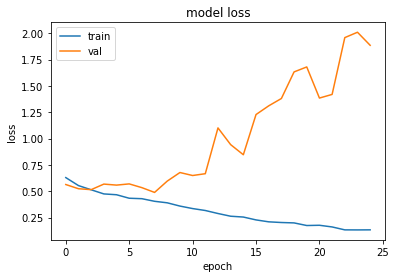

[[6423 3158]
 [ 190  577]]
F1 score: 0.2563305197689915
Precision: 0.15448460508701473
Recall: 0.7522816166883963
Accuracy: 0.6764592191727871
ROC AUC: 0.7113354644343767


In [49]:
nn_kfold(df_mlp_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 101, 64)           4160      
__________

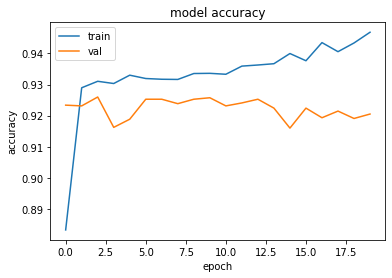

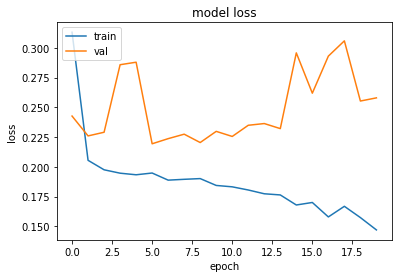

[[9348  233]
 [ 585  182]]
F1 score: 0.3079526226734349
Precision: 0.43855421686746987
Recall: 0.23728813559322035
Accuracy: 0.9209509083880943
ROC AUC: 0.6064845854878741


In [50]:
cnn(df_mlp_sub2)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_364 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_319 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_320 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_321 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 260us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.4313328904150964;  accuracy of 0.7616735696792603; precision of 0.7616735696792603; recall of 0.7616735696792603; AUC of 0.8077372312545776;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 263us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0712197271565207;  accuracy of 0.762101948261261; precision of 0.762101948261261; recall of 0.762101948261261; AUC of 0.8097773790359497;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 274us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.3411064476825911;  accuracy of 0.6765671968460083; precision of 0.6765671968460083; recall of 0.6765671968460083; AUC of 0.7438409924507141;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


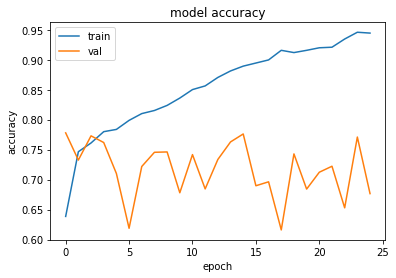

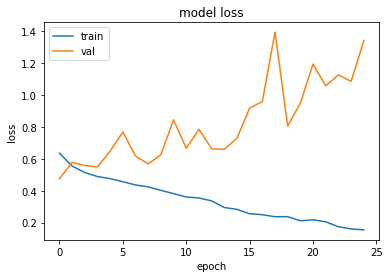

[[6404 3177]
 [ 196  571]]
F1 score: 0.2529346622369878
Precision: 0.1523479188900747
Recall: 0.7444589308996089
Accuracy: 0.6740432933900271
ROC AUC: 0.7064325757723177


In [51]:
nn_kfold(df_mlp_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 101, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


4202/4202 [==============================] - 10s 2ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.7957819328882307;  accuracy of 0.7289385795593262; precision of 0.7289385795593262; recall of 0.7289385795593262; AUC of 0.8003073334693909;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


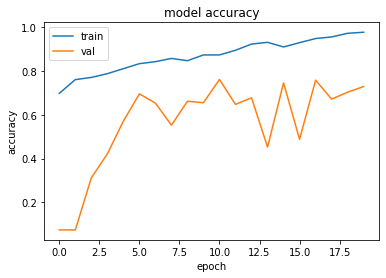

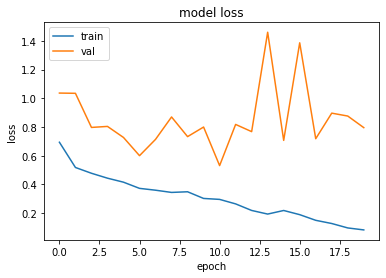

[[7147 2434]
 [ 264  503]]
F1 score: 0.27159827213822896
Precision: 0.17126319373510385
Recall: 0.6558018252933507
Accuracy: 0.7392732895245459
ROC AUC: 0.700878681146832


In [52]:
cnn(df_mlp_sub2, balanced_batches=True)

## Created new features (categorical)

In [55]:
df_raw_mlp_ext =  pd.read_csv('df_feature_mlp_ext.csv')

df_ext_square = df_raw_mlp_ext[df_raw_mlp_ext.columns.drop(list(df_raw_mlp_ext.filter(regex='_2')))]

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_196 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_197 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_198 (Dropout)        (None, 100)               0         
__________

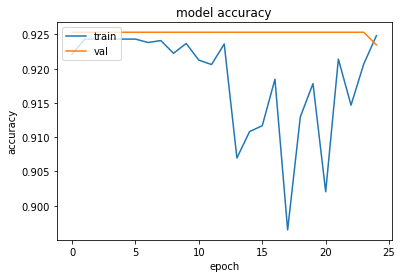

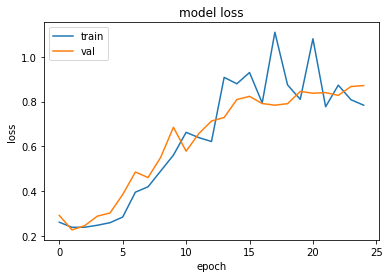

[[9466  115]
 [ 662  105]]
F1 score: 0.21276595744680854
Precision: 0.4772727272727273
Recall: 0.13689700130378096
Accuracy: 0.9249130266718206
ROC AUC: 0.5624470394265486


In [39]:
nn_kfold(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 186, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 185, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 185, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 184, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 184, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 183, 64)           4160      
__________

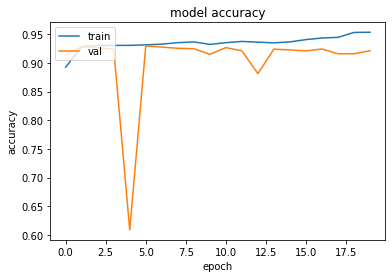

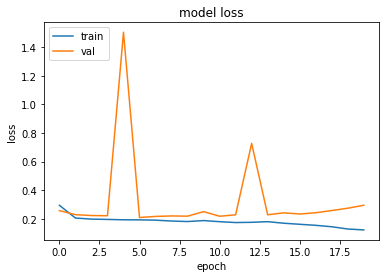

[[9377  204]
 [ 608  159]]
F1 score: 0.2814159292035398
Precision: 0.4380165289256198
Recall: 0.20730117340286833
Accuracy: 0.9215307305759567
ROC AUC: 0.5930045163538713


In [40]:
cnn(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_221 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_253 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_222 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_254 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_223 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 270us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.242154469272843;  accuracy of 0.723975419998169; precision of 0.723975419998169; recall of 0.723975419998169; AUC of 0.7389461994171143;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 261us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.641159088428099;  accuracy of 0.7423961162567139; precision of 0.7423961162567139; recall of 0.7423961162567139; AUC of 0.7795184254646301;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 232us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.774083107109838;  accuracy of 0.7268313765525818; precision of 0.7268313765525818; recall of 0.7268313765525818; AUC of 0.780707061290741;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


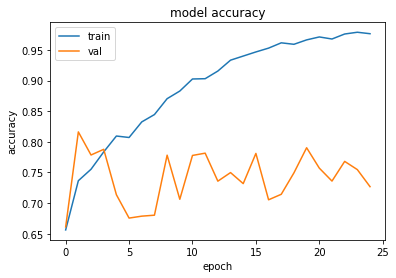

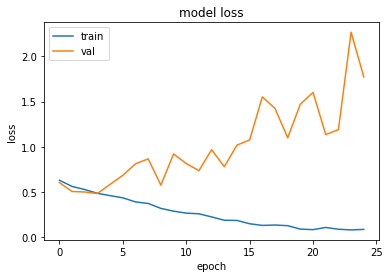

[[6849 2732]
 [ 215  552]]
F1 score: 0.2725253023944705
Precision: 0.16808769792935443
Recall: 0.7196870925684485
Accuracy: 0.7152106687282567
ROC AUC: 0.7172697022178428


In [41]:
nn_kfold(df_ext_square, balanced_batches=True)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 186, 1)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 185, 32)           96        
_________________________________________________________________
batch_normalization_51 (Batc (None, 185, 32)           128       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 184, 32)           2080      
_________________________________________________________________
batch_normalization_52 (Batc (None, 184, 32)           128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 183, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 57s 720ms/step - loss: 0.7087 - accuracy: 0.7077 - precision: 0.7077 - recall: 0.7077 - AUC: 0.7611 - val_loss: 1.0786 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1103
Epoch 2/20
79/79 [==============================] - 39s 490ms/step - loss: 0.5093 - accuracy: 0.7572 - precision: 0.7572 - recall: 0.7572 - AUC: 0.8392 - val_loss: 1.1746 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1154
Epoch 3/20
79/79 [==============================] - 35s 446ms/step - loss: 0.4367 - accuracy: 0.7999 - precision: 0.7999 - recall: 0.7999 - AUC: 0.8775 - val_loss: 1.1066 - val_accuracy: 0.0764 - val_precision: 0.0764 - val_recall: 0.0764 - val_AUC: 0.1143
Epoch 4/20
79/79 [==============================] - 37s 470ms/step - loss: 0.3909 - accuracy: 0.8267 - precision: 0.8267 - recall: 0.8267 - AUC: 0.9039 - val_loss: 1.1211 - val_accuracy: 0.1454 - val_precision: 0.1454 - val_recal

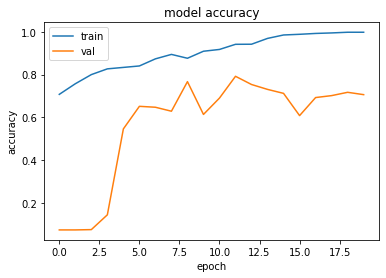

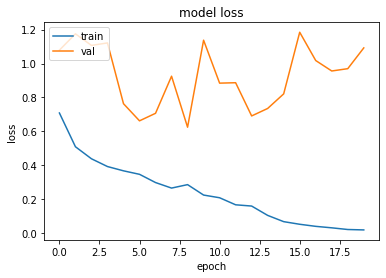

[[6795 2786]
 [ 216  551]]
F1 score: 0.2685185185185185
Precision: 0.16511836979322744
Recall: 0.7183833116036505
Accuracy: 0.7098956320061848
ROC AUC: 0.7137997342905008


In [57]:
cnn(df_ext_square, balanced_batches=True)

## Created + log(cont)

In [56]:
df_created_log = df_ext_square.copy()

cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_log[str(var) + '_log'] = (df_created_log[var]-df_created_log[var].min()+1).transform(np.log)


df_created_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,4.008530,3.695155,6.647488,6.059859,0.0,0.693147,1.098612,5.105351,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,4.294399,3.870154,6.647488,6.398484,0.0,1.098612,1.098612,4.976058,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,4.183561,3.827840,6.647488,5.849718,0.0,0.693147,0.693147,4.976058,0.189621,5.668580
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,4.212974,3.904984,6.647488,6.432172,0.0,1.098612,2.197225,4.794980,0.260884,5.734725
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,4.091513,3.764584,6.647488,6.203271,0.0,0.000000,1.945910,4.761336,0.301325,6.287247


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               48000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
___________

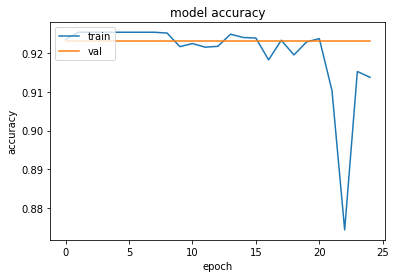

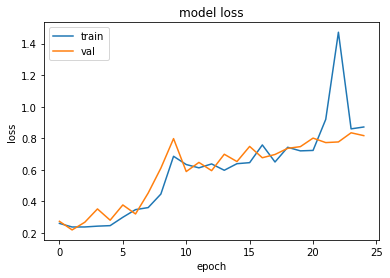

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
nn_kfold(df_created_log)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 236, 64)           4160      
___________

4202/4202 [==============================] - 24s 6ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.3441083791077506;  accuracy of 0.9207520484924316; precision of 0.9207520484924316; recall of 0.9207520484924316; AUC of 0.9577266573905945;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


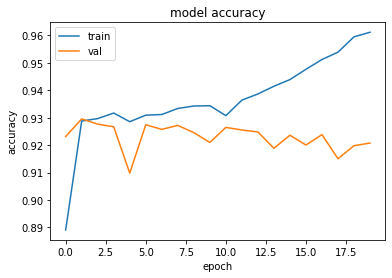

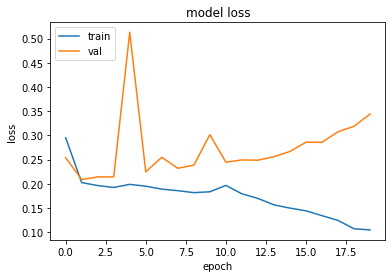

[[9353  228]
 [ 590  177]]
F1 score: 0.3020477815699659
Precision: 0.43703703703703706
Recall: 0.23076923076923078
Accuracy: 0.9209509083880943
ROC AUC: 0.6034860661726333


In [17]:
cnn(df_created_log)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               48000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



7003/7003 [==============================] - 6s 891us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.1734301310070374;  accuracy of 0.7049835920333862; precision of 0.7049835920333862; recall of 0.7049835920333862; AUC of 0.7281454801559448;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 7s 943us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.257979959364399;  accuracy of 0.7292588949203491; precision of 0.7292588949203491; recall of 0.7292588949203491; AUC of 0.8141670227050781;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 6s 889us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.125019983684916;  accuracy of 0.7232614755630493; precision of 0.7232614755630493; recall of 0.7232614755630493; AUC of 0.745728075504303;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


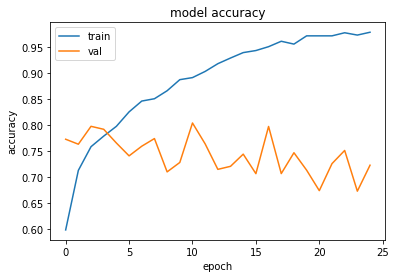

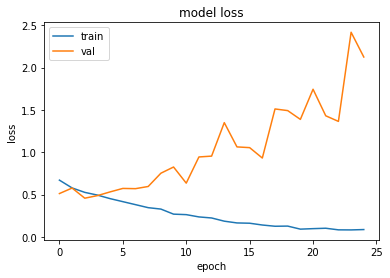

[[6703 2878]
 [ 212  555]]
F1 score: 0.2642857142857143
Precision: 0.1616661811826391
Recall: 0.7235984354628422
Accuracy: 0.7013915732508698
ROC AUC: 0.7116061272398232


In [15]:
nn_kfold(df_created_log, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 236, 64)           4160      
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 106s 1s/step - loss: 0.6603 - accuracy: 0.7128 - precision: 0.7128 - recall: 0.7128 - AUC: 0.7668 - val_loss: 1.0809 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1174
Epoch 2/20
79/79 [==============================] - 82s 1s/step - loss: 0.4942 - accuracy: 0.7676 - precision: 0.7676 - recall: 0.7676 - AUC: 0.8442 - val_loss: 1.2355 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1202
Epoch 3/20
79/79 [==============================] - 82s 1s/step - loss: 0.4501 - accuracy: 0.7955 - precision: 0.7955 - recall: 0.7955 - AUC: 0.8707 - val_loss: 1.0816 - val_accuracy: 0.0971 - val_precision: 0.0971 - val_recall: 0.0971 - val_AUC: 0.1214
Epoch 4/20
79/79 [==============================] - 80s 1s/step - loss: 0.4031 - accuracy: 0.8159 - precision: 0.8159 - recall: 0.8159 - AUC: 0.8986 - val_loss: 1.0100 - val_accuracy: 0.2087 - val_precision: 0.2087 - val_recall: 0.2087 -

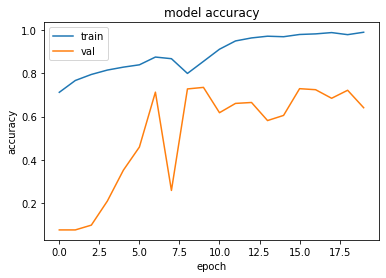

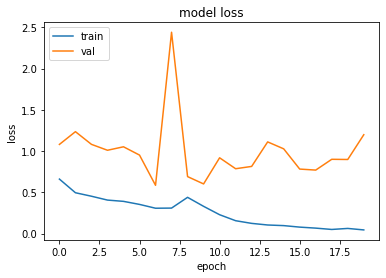

[[6145 3436]
 [ 199  568]]
F1 score: 0.23810521903164955
Precision: 0.14185814185814186
Recall: 0.7405475880052151
Accuracy: 0.6487243911867028
ROC AUC: 0.690960569913264


In [16]:
cnn(df_created_log, balanced_batches=True)

## Created + sqrt

In [57]:
df_created_sqrt = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sqrt[str(var) + '_sqrt'] = (df_created_sqrt[var]-df_created_sqrt[var].min()+1).transform(np.sqrt)


df_created_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,7.420638,6.344433,27.764101,20.695776,1.0,1.414214,1.732051,12.841418,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,8.560850,6.924577,27.764101,24.513938,1.0,1.732051,1.732051,12.037526,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,8.099324,6.779613,27.764101,18.631603,1.0,1.414214,1.414214,12.037526,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,8.219316,7.046225,27.764101,24.930352,1.0,1.732051,3.000000,10.995546,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,7.735007,6.568543,27.764101,22.234283,1.0,1.000000,2.645751,10.812124,1.162604,23.187734


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

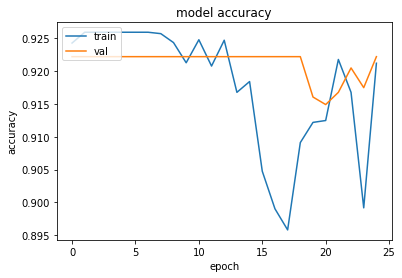

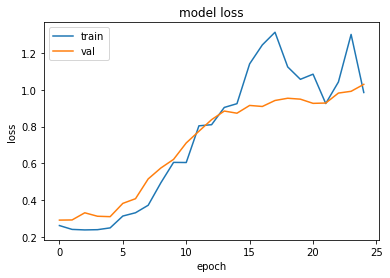

[[9510   71]
 [ 705   62]]
F1 score: 0.13777777777777778
Precision: 0.46616541353383456
Recall: 0.08083441981747067
Accuracy: 0.9250096637031311
ROC AUC: 0.5367119599348286


In [18]:
nn_kfold(df_created_sqrt)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 64)           4160      
___________

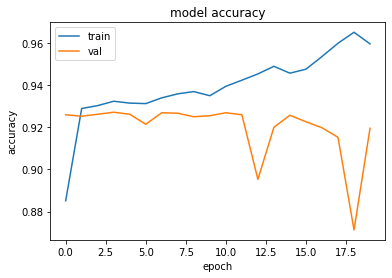

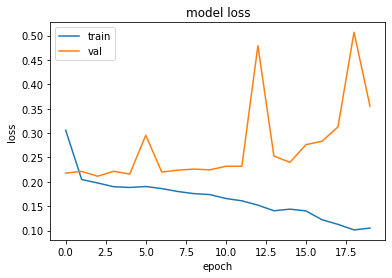

[[9367  214]
 [ 605  162]]
F1 score: 0.28346456692913385
Precision: 0.4308510638297872
Recall: 0.21121251629726207
Accuracy: 0.9208542713567839
ROC AUC: 0.5944383216075602


In [20]:
cnn(df_created_sqrt)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_50 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 217us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.5308293275929818;  accuracy of 0.7124089598655701; precision of 0.7124089598655701; recall of 0.7124089598655701; AUC of 0.7750372290611267;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 210us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.315272226582829;  accuracy of 0.7086962461471558; precision of 0.7086962461471558; recall of 0.7086962461471558; AUC of 0.7189202308654785;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 204us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.08550928307315;  accuracy of 0.705411970615387; precision of 0.705411970615387; recall of 0.705411970615387; AUC of 0.7215359807014465;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


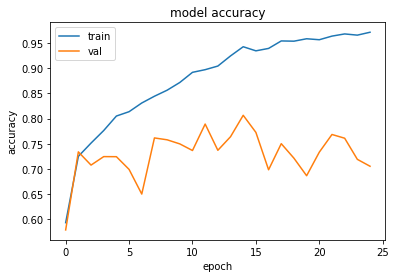

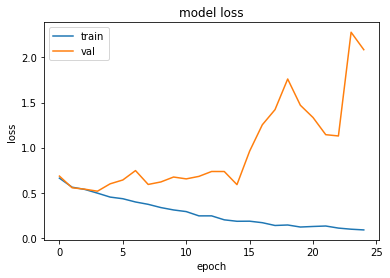

[[6597 2984]
 [ 196  571]]
F1 score: 0.2642295233688107
Precision: 0.16061884669479606
Recall: 0.7444589308996089
Accuracy: 0.6926942404329339
ROC AUC: 0.7165045933070219


In [19]:
nn_kfold(df_created_sqrt, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 50s 637ms/step - loss: 0.7200 - accuracy: 0.7061 - precision: 0.7061 - recall: 0.7061 - AUC: 0.7708 - val_loss: 0.7540 - val_accuracy: 0.1552 - val_precision: 0.1552 - val_recall: 0.1552 - val_AUC: 0.1340
Epoch 2/20
79/79 [==============================] - 44s 553ms/step - loss: 0.5002 - accuracy: 0.7688 - precision: 0.7688 - recall: 0.7688 - AUC: 0.8438 - val_loss: 0.7150 - val_accuracy: 0.4681 - val_precision: 0.4681 - val_recall: 0.4681 - val_AUC: 0.4407
Epoch 3/20
79/79 [==============================] - 43s 545ms/step - loss: 0.4581 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - AUC: 0.8660 - val_loss: 0.6356 - val_accuracy: 0.6828 - val_precision: 0.6828 - val_recall: 0.6828 - val_AUC: 0.7351
Epoch 4/20
79/79 [==============================] - 43s 540ms/step - loss: 0.4030 - accuracy: 0.8219 - precision: 0.8219 - recall: 0.8219 - AUC: 0.8975 - val_loss: 0.4803 - val_accuracy: 0.8053 - val_precision: 0.8053 - val_recal

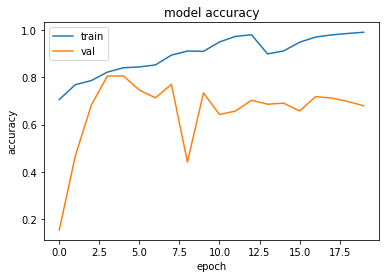

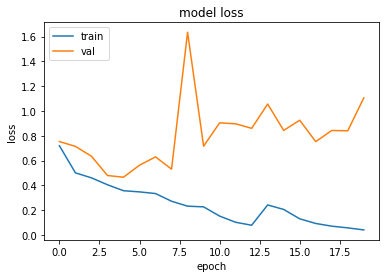

[[6487 3094]
 [ 199  568]]
F1 score: 0.25649130729284264
Precision: 0.15510649918077554
Recall: 0.7405475880052151
Accuracy: 0.681774255894859
ROC AUC: 0.708808393731237


In [20]:
cnn(df_created_sqrt, balanced_batches=True)

## subset of created columns - minimize correlation

In [58]:
subset_corr = ['depressed', 'broken_hip','edu_level', 'gender', 'marital_status', 'protein', 
       'sugar', 'fiber', 'fat', 'magnesium', 'iron', 'zinc', 'selenium', 'water', 
       'how_healthy_diet', 'gen_health_cond', 'healthcare_past_yr', 'health_insurance',
        'home_ownership', 'food_security_cat', 'work_type', 'hrs_worked_week',
       'embarassed_mouth', 'manage_$_difficult', 'doc_sleeping_disorder',
       'hrs_sleep', 'smoked_5days', 'sexual_orientation',  'consider_weight','triglyceride', 
               'tot_cholesterol', 'rbc_folate',
       'fasting_glucose', 'lab_VitD', 'pulse', 'BMI', 
       'monthly_income', 'oral_rec', 'difficult_remembering', 'prob_smell', 'prob_tatse',
       'persistent_cold',  'serum_selenium', 'serum_zinc', 'serum_creatinine', 'lab_VitB12',
        'doc_COPD', 'age_cat', 'not_enough_food', 'food_welfare', 'chronic_condition',
       '#_chronic_condition', 'active', 'hours_screen', 'limited',
       'taste_smell', 'difficult_everyday', 'combined_BP',
       'drugs_alcohol', 'people_per_rooms', 'sexuality', 'race_cat',
       'diet_tot_VitB']

df_min_corr = df_ext_square[subset_corr]

In [36]:
df_min_corr.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,hours_screen,limited,taste_smell,difficult_everyday,combined_BP,drugs_alcohol,people_per_rooms,sexuality,race_cat,diet_tot_VitB
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,2.0,0.0,0.0,0.0,218.0,0.0,0.500000,0.0,3.0,300.415
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,2.0,0.0,0.0,0.0,198.0,0.0,0.250000,0.0,2.0,814.422
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,1.0,0.0,0.0,0.0,198.0,0.0,0.285714,0.0,2.0,288.623
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,8.0,0.0,0.0,0.0,174.0,0.0,0.375000,0.0,1.0,308.428
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,6.0,0.0,0.0,0.0,170.0,0.0,0.428571,0.0,2.0,536.671


Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 200)               21200     
_________________________________________________________________
dropout_50 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
___________

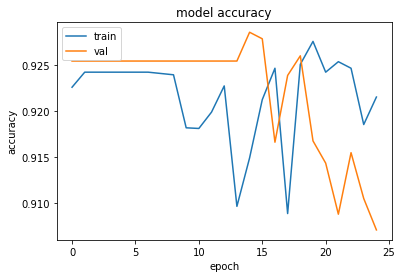

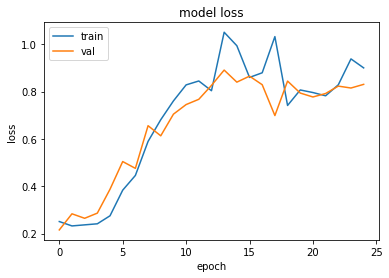

[[9128  453]
 [ 558  209]]
F1 score: 0.2925122463261022
Precision: 0.3157099697885196
Recall: 0.27249022164276404
Accuracy: 0.9022999613451875
ROC AUC: 0.6126045722554704


In [24]:
nn_kfold(df_min_corr)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 105, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 104, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 104, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 103, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 103, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 102, 64)           4160      
__________

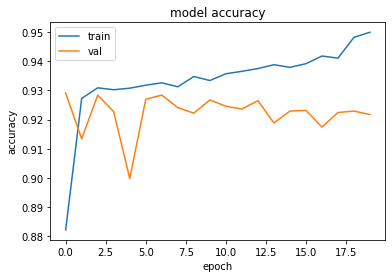

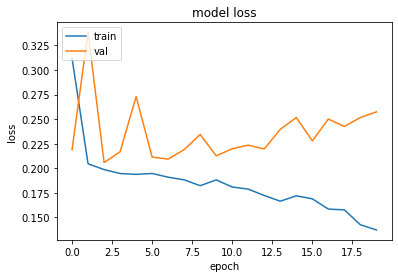

[[9319  262]
 [ 585  182]]
F1 score: 0.30057803468208094
Precision: 0.4099099099099099
Recall: 0.23728813559322035
Accuracy: 0.9181484344800928
ROC AUC: 0.6049711735267009


In [25]:
cnn(df_min_corr)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 200)               21200     
_________________________________________________________________
dropout_75 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_77 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 199us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.180022332049703;  accuracy of 0.6692845821380615; precision of 0.6692845821380615; recall of 0.6692845821380615; AUC of 0.6577305197715759;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 210us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.036551552654317;  accuracy of 0.7102670073509216; precision of 0.7102670073509216; recall of 0.7102670073509216; AUC of 0.79232257604599;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 199us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.8238665208499227;  accuracy of 0.7448236346244812; precision of 0.7448236346244812; recall of 0.7448236346244812; AUC of 0.7464415431022644;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


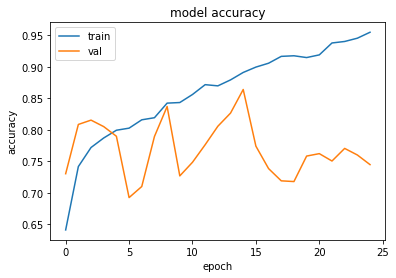

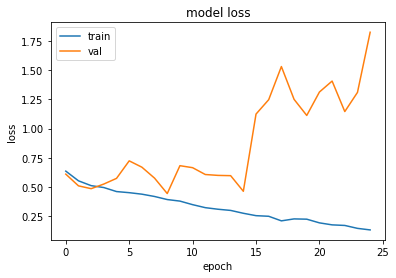

[[7036 2545]
 [ 230  537]]
F1 score: 0.2790335151987529
Precision: 0.17423750811161584
Recall: 0.7001303780964798
Accuracy: 0.7318322381136452
ROC AUC: 0.7172502428004578


In [26]:
nn_kfold(df_min_corr, balanced_batches=True)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 105, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 104, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 104, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 103, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 102, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 31s 393ms/step - loss: 0.6485 - accuracy: 0.7180 - precision: 0.7180 - recall: 0.7180 - AUC: 0.7828 - val_loss: 0.8957 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1192
Epoch 2/20
79/79 [==============================] - 23s 296ms/step - loss: 0.5074 - accuracy: 0.7560 - precision: 0.7560 - recall: 0.7560 - AUC: 0.8343 - val_loss: 0.9160 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1193
Epoch 3/20
79/79 [==============================] - 23s 292ms/step - loss: 0.4583 - accuracy: 0.7796 - precision: 0.7796 - recall: 0.7796 - AUC: 0.8644 - val_loss: 1.1464 - val_accuracy: 0.0759 - val_precision: 0.0759 - val_recall: 0.0759 - val_AUC: 0.1194
Epoch 4/20
79/79 [==============================] - 22s 284ms/step - loss: 0.4446 - accuracy: 0.7895 - precision: 0.7895 - recall: 0.7895 - AUC: 0.8723 - val_loss: 1.0057 - val_accuracy: 0.1637 - val_precision: 0.1637 - val_recal

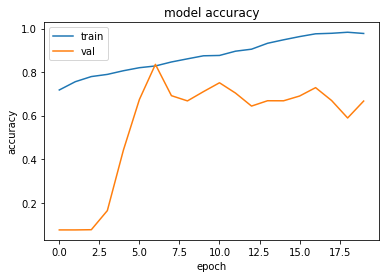

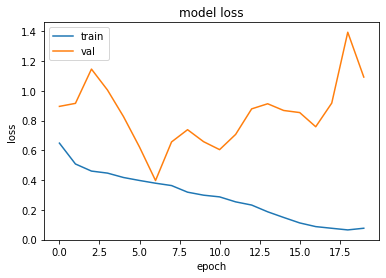

[[6518 3063]
 [ 216  551]]
F1 score: 0.2515407441223465
Precision: 0.15246264526840067
Recall: 0.7183833116036505
Accuracy: 0.6831271743332045
ROC AUC: 0.6993440407303296


In [27]:
cnn(df_min_corr, balanced_batches=True)

## Subset of created + log

In [59]:
df_sub_log = df_min_corr.copy()

cont, non_cont, cat_encode, = var_type(df_sub_log)

# log of all cont columns
for var in cont:
    df_sub_log[str(var) + '_log'] = (df_sub_log[var]-df_sub_log[var].min()+1).transform(np.log)


df_sub_log.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,monthly_income_log,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,3.154667,4.008530,3.695155,6.647488,6.059859,0.693147,1.098612,5.105351,0.352821,5.708488
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,3.056272,4.294399,3.870154,6.647488,6.398484,1.098612,1.098612,4.976058,0.159630,6.703706
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,2.880598,4.183561,3.827840,6.647488,5.849718,0.693147,0.693147,4.976058,0.189621,5.668580
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,2.993584,4.212974,3.904984,6.647488,6.432172,1.098612,2.197225,4.794980,0.260884,5.734725
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,2.966812,4.091513,3.764584,6.647488,6.203271,0.000000,1.945910,4.761336,0.301325,6.287247


Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 200)               27200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
__________

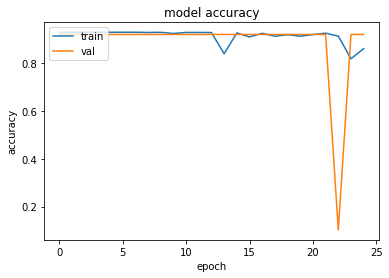

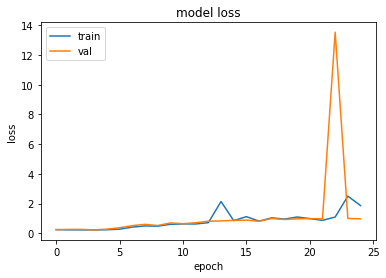

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
nn_kfold(df_sub_log)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 135, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 134, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 134, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 133, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 133, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 132, 64)           4160      
___________

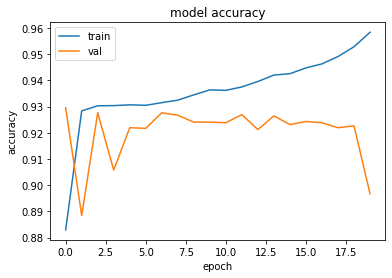

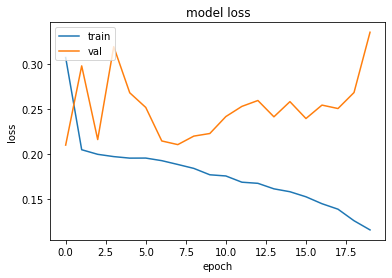

[[9036  545]
 [ 499  268]]
F1 score: 0.3392405063291139
Precision: 0.3296432964329643
Recall: 0.3494132985658409
Accuracy: 0.8991109393119443
ROC AUC: 0.6462649417367353


In [28]:
cnn(df_sub_log)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 200)               27200     
_________________________________________________________________
dropout_72 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_73 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_74 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 235us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.4130086944934965;  accuracy of 0.6932743191719055; precision of 0.6932743191719055; recall of 0.6932743191719055; AUC of 0.728257954120636;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 262us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.8624358579769622;  accuracy of 0.79023277759552; precision of 0.79023277759552; recall of 0.79023277759552; AUC of 0.8587884306907654;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 235us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.6300848212886262;  accuracy of 0.793374240398407; precision of 0.793374240398407; recall of 0.793374240398407; AUC of 0.8944835066795349;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


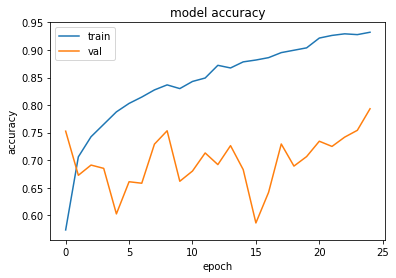

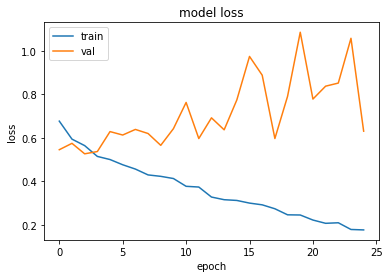

[[7681 1900]
 [ 309  458]]
F1 score: 0.29311999999999994
Precision: 0.19423240033927056
Recall: 0.5971316818774446
Accuracy: 0.7865287978353305
ROC AUC: 0.6994112641722052


In [73]:
nn_kfold(df_sub_log, balanced_batches=True)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 135, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 134, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 134, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 133, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 133, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 132, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 34s 434ms/step - loss: 0.7468 - accuracy: 0.7053 - precision: 0.7053 - recall: 0.7053 - AUC: 0.7573 - val_loss: 0.4907 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250 - val_AUC: 0.9671
Epoch 2/20
79/79 [==============================] - 25s 321ms/step - loss: 0.5143 - accuracy: 0.7516 - precision: 0.7516 - recall: 0.7516 - AUC: 0.8315 - val_loss: 0.7236 - val_accuracy: 0.3458 - val_precision: 0.3458 - val_recall: 0.3458 - val_AUC: 0.3170
Epoch 3/20
79/79 [==============================] - 25s 322ms/step - loss: 0.4642 - accuracy: 0.7859 - precision: 0.7859 - recall: 0.7859 - AUC: 0.8634 - val_loss: 0.6210 - val_accuracy: 0.7061 - val_precision: 0.7061 - val_recall: 0.7061 - val_AUC: 0.7669
Epoch 4/20
79/79 [==============================] - 26s 329ms/step - loss: 0.4278 - accuracy: 0.7951 - precision: 0.7951 - recall: 0.7951 - AUC: 0.8847 - val_loss: 0.5239 - val_accuracy: 0.7965 - val_precision: 0.7965 - val_recal

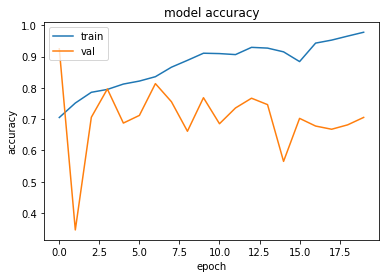

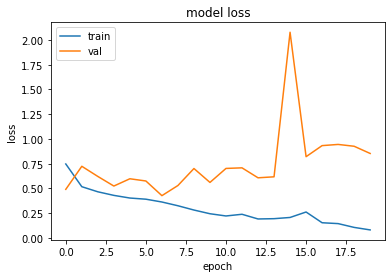

[[6784 2797]
 [ 225  542]]
F1 score: 0.26400389673648317
Precision: 0.16232404911650195
Recall: 0.7066492829204694
Accuracy: 0.7079628913799768
ROC AUC: 0.7073586671360514


In [74]:
cnn(df_sub_log, balanced_batches=True)

## Subset + log + sqrt

In [24]:
df_sub_log_sqrt = df_sub_log.copy()

# cont, non_cont, cat_encode, = var_type(df_sub_log_sqrt)

# log of all cont columns
for var in cont:
    df_sub_log_sqrt[str(var) + '_sqrt'] = (df_sub_log_sqrt[var]-df_sub_log_sqrt[var].min()+1).transform(np.sqrt)


df_sub_log_sqrt.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,monthly_income_sqrt,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,4.842028,7.420638,6.344433,27.764101,20.695776,1.414214,1.732051,12.841418,1.192928,17.361308
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,4.609576,8.560850,6.924577,27.764101,24.513938,1.732051,1.732051,12.037526,1.083087,28.555595
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,4.221958,8.099324,6.779613,27.764101,18.631603,1.414214,1.414214,12.037526,1.099450,17.018314
3,0.0,0.0,4.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,4.467334,8.219316,7.046225,27.764101,24.930352,1.732051,3.000000,10.995546,1.139332,17.590566
4,0.0,0.0,4.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,4.407933,7.735007,6.568543,27.764101,22.234283,1.000000,2.645751,10.812124,1.162604,23.187734


Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 200)               33200     
_________________________________________________________________
dropout_97 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_98 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_99 (Dropout)         (None, 100)               0         
__________

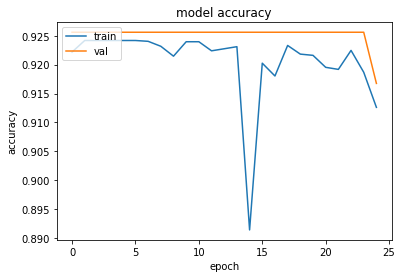

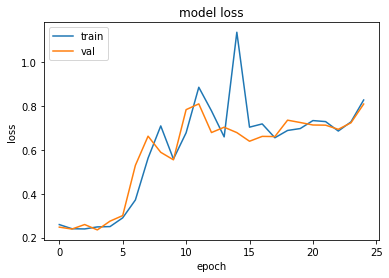

[[9475  106]
 [ 754   13]]
F1 score: 0.02934537246049661
Precision: 0.1092436974789916
Recall: 0.01694915254237288
Accuracy: 0.9168921530730576
ROC AUC: 0.5029427946200018


In [75]:
nn_kfold(df_sub_log_sqrt)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 165, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 164, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 163, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 163, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 162, 64)           4160      
___________

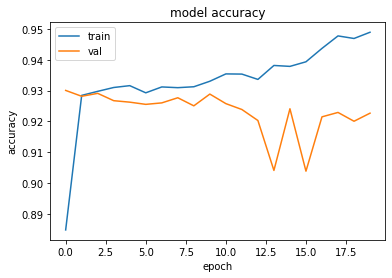

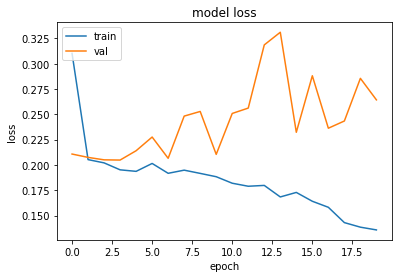

[[9373  208]
 [ 604  163]]
F1 score: 0.28646748681898065
Precision: 0.4393530997304582
Recall: 0.21251629726205998
Accuracy: 0.9215307305759567
ROC AUC: 0.5954033318060639


In [59]:
cnn(df_sub_log_sqrt)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_143 (Dense)            (None, 200)               33200     
_________________________________________________________________
dropout_121 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_122 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_123 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 185us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.9872007195853887;  accuracy of 0.7455376386642456; precision of 0.7455376386642456; recall of 0.7455376386642456; AUC of 0.8175829648971558;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 185us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.6725842715773637;  accuracy of 0.828644871711731; precision of 0.828644871711731; recall of 0.828644871711731; AUC of 0.8971473574638367;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 196us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.2442052850344685;  accuracy of 0.6935598850250244; precision of 0.6935598850250244; recall of 0.6935598850250244; AUC of 0.7490714192390442;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


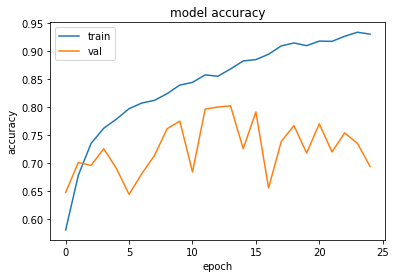

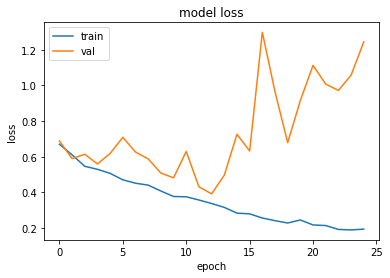

[[6463 3118]
 [ 209  558]]
F1 score: 0.2511816340310601
Precision: 0.15179542981501631
Recall: 0.727509778357236
Accuracy: 0.6784885968303054
ROC AUC: 0.7010370100428284


In [76]:
nn_kfold(df_sub_log_sqrt, balanced_batches=True)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 165, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 164, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 163, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 163, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 162, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 39s 491ms/step - loss: 0.6735 - accuracy: 0.7191 - precision: 0.7191 - recall: 0.7191 - AUC: 0.7701 - val_loss: 0.8572 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1089
Epoch 2/20
79/79 [==============================] - 29s 369ms/step - loss: 0.5103 - accuracy: 0.7656 - precision: 0.7656 - recall: 0.7656 - AUC: 0.8356 - val_loss: 0.8770 - val_accuracy: 0.0757 - val_precision: 0.0757 - val_recall: 0.0757 - val_AUC: 0.1154
Epoch 3/20
79/79 [==============================] - 29s 369ms/step - loss: 0.4717 - accuracy: 0.7756 - precision: 0.7756 - recall: 0.7756 - AUC: 0.8549 - val_loss: 0.9009 - val_accuracy: 0.1283 - val_precision: 0.1283 - val_recall: 0.1283 - val_AUC: 0.1288
Epoch 4/20
79/79 [==============================] - 29s 368ms/step - loss: 0.4415 - accuracy: 0.8011 - precision: 0.8011 - recall: 0.8011 - AUC: 0.8757 - val_loss: 0.7246 - val_accuracy: 0.5312 - val_precision: 0.5312 - val_recal

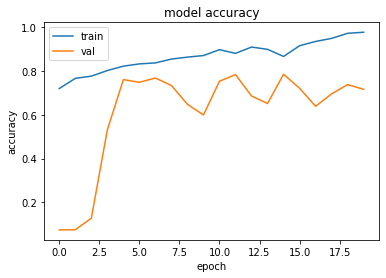

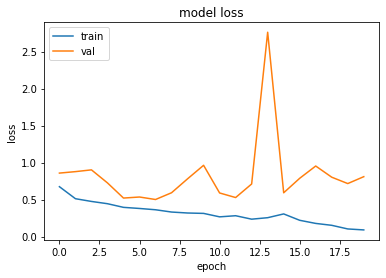

[[6796 2785]
 [ 230  537]]
F1 score: 0.26265590608950845
Precision: 0.16164960866947622
Recall: 0.7001303780964798
Accuracy: 0.7086393505991496
ROC AUC: 0.7047254541562662


In [77]:
cnn(df_sub_log_sqrt, balanced_batches=True)

## All created + polynomial

In [64]:
df_created_poly = df_ext_square.copy()

# 1+5x+8x2
for var in cont:
    df_created_poly[str(var) + '_poly'] = (1+(5*df_created_poly[var])+(8*np.power(df_created_poly[var],2)))


df_created_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,monthly_income_poly,serum_selenium_poly,serum_zinc_poly,serum_creatinine_poly,lab_VitB12_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,3094.507441,101211.272474,40287.701172,88.522416,1.588672e+06,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,2441.780413,136661.496861,49502.234753,88.522416,3.057822e+06,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,1578.669419,121054.957850,47033.470382,88.522416,1.062586e+06,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,2094.226256,124939.545031,51664.352692,88.522416,3.264881e+06,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,1959.979396,109967.276169,43640.559569,88.522416,2.094498e+06,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 200)               43400     
_________________________________________________________________
dropout_50 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
___________

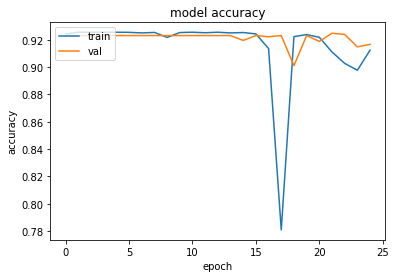

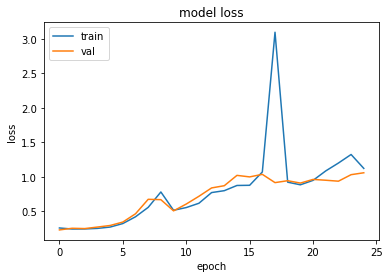

[[9418  163]
 [ 678   89]]
F1 score: 0.1746810598626104
Precision: 0.3531746031746032
Recall: 0.11603650586701435
Accuracy: 0.9187282566679552
ROC AUC: 0.549511833979327


In [65]:
nn_kfold(df_created_poly)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 216, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 215, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 215, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 214, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 214, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 213, 64)           4160      
__________

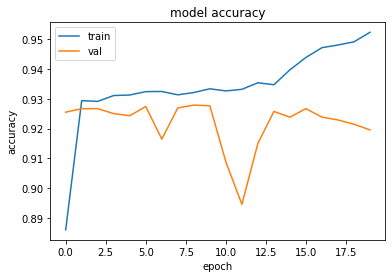

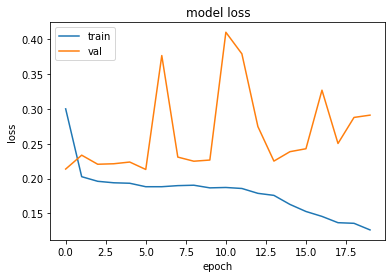

[[9303  278]
 [ 583  184]]
F1 score: 0.29943043124491453
Precision: 0.39826839826839827
Recall: 0.23989569752281617
Accuracy: 0.9167955160417472
ROC AUC: 0.6054399685818861


In [66]:
cnn(df_created_poly)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 200)               43400     
_________________________________________________________________
dropout_75 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_77 (Dropout)         (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 219us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.0859156258528735;  accuracy of 0.7483935356140137; precision of 0.7483935356140137; recall of 0.7483935356140137; AUC of 0.762757420539856;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 219us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.028623981883011;  accuracy of 0.7692417502403259; precision of 0.7692417502403259; recall of 0.7692417502403259; AUC of 0.804998517036438;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 220us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.1018913000902923;  accuracy of 0.7089818716049194; precision of 0.7089818716049194; recall of 0.7089818716049194; AUC of 0.7476494908332825;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


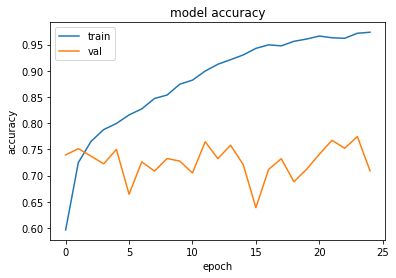

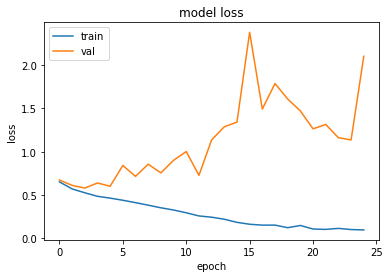

[[6754 2827]
 [ 207  560]]
F1 score: 0.2696196437168994
Precision: 0.165338057277827
Recall: 0.7301173402868318
Accuracy: 0.706803247004252
ROC AUC: 0.7175270972387088


In [67]:
nn_kfold(df_created_poly, balanced_batches=True)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 216, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 215, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 215, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 214, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 214, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 213, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 47s 599ms/step - loss: 0.6680 - accuracy: 0.7053 - precision: 0.7053 - recall: 0.7053 - AUC: 0.7692 - val_loss: 0.6584 - val_accuracy: 0.7151 - val_precision: 0.7151 - val_recall: 0.7151 - val_AUC: 0.7748
Epoch 2/20
79/79 [==============================] - 39s 498ms/step - loss: 0.5118 - accuracy: 0.7644 - precision: 0.7644 - recall: 0.7644 - AUC: 0.8341 - val_loss: 0.8709 - val_accuracy: 0.1007 - val_precision: 0.1007 - val_recall: 0.1007 - val_AUC: 0.1213
Epoch 3/20
79/79 [==============================] - 40s 509ms/step - loss: 0.4574 - accuracy: 0.7867 - precision: 0.7867 - recall: 0.7867 - AUC: 0.8653 - val_loss: 0.7183 - val_accuracy: 0.5002 - val_precision: 0.5002 - val_recall: 0.5002 - val_AUC: 0.4880
Epoch 4/20
79/79 [==============================] - 39s 498ms/step - loss: 0.4377 - accuracy: 0.7967 - precision: 0.7967 - recall: 0.7967 - AUC: 0.8783 - val_loss: 0.7379 - val_accuracy: 0.5238 - val_precision: 0.5238 - val_recal

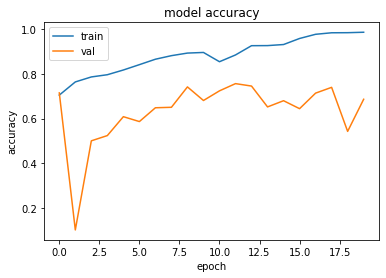

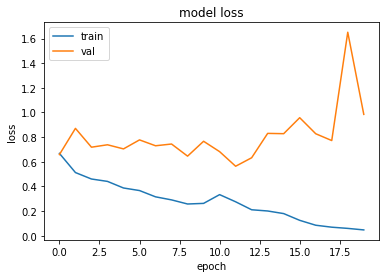

[[6672 2909]
 [ 229  538]]
F1 score: 0.2553393450403417
Precision: 0.1560777487670438
Recall: 0.7014341590612777
Accuracy: 0.6967529957479707
ROC AUC: 0.6989062038391662


In [68]:
cnn(df_created_poly, balanced_batches=True)

## Created +sin()

In [69]:
df_created_sin = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sin[str(var) + '_sin'] = np.sin(df_created_sin[var])


df_created_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,monthly_income_sin,serum_selenium_sin,serum_zinc_sin,serum_creatinine_sin,lab_VitB12_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,0.483652,-0.802501,0.999422,0.13137,-0.711071,0.841471,0.909297,-0.942525,0.479426,-0.923802
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,-0.992637,-0.999927,0.188909,0.13137,0.819520,0.909297,0.909297,-0.079579,0.247404,-0.681275
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,0.919853,-0.176019,0.822011,0.13137,-0.284155,0.841471,0.841471,-0.079579,0.281843,-0.392662
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,-0.157596,-0.844990,-0.998120,0.13137,-0.702676,0.909297,0.989358,-0.936462,0.366273,0.524323
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,0.360630,-0.637621,-0.960593,0.13137,0.656555,0.000000,-0.279415,0.346649,0.415572,0.515288


Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 200)               43400     
_________________________________________________________________
dropout_100 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_116 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_117 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_102 (Dropout)        (None, 100)               0         
__________

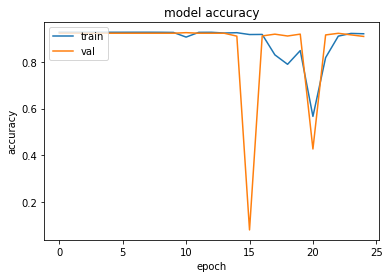

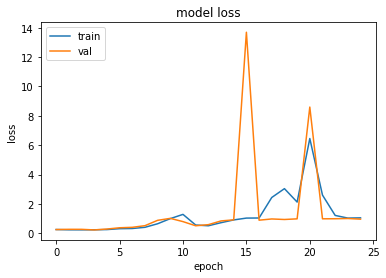

[[9251  330]
 [ 618  149]]
F1 score: 0.23916532905296953
Precision: 0.31106471816283926
Recall: 0.19426336375488917
Accuracy: 0.9083880943177426
ROC AUC: 0.5799100974916811


In [70]:
nn_kfold(df_created_sin)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 216, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 215, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 215, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 214, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 214, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 213, 64)           4160      
__________

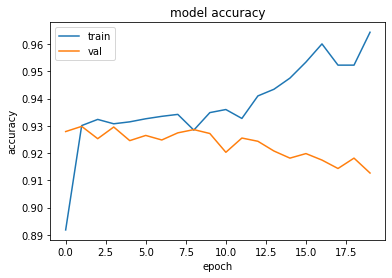

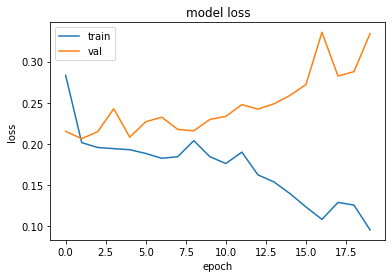

[[9274  307]
 [ 584  183]]
F1 score: 0.29116945107398573
Precision: 0.373469387755102
Recall: 0.23859191655801826
Accuracy: 0.9138964051024353
ROC AUC: 0.6032746661383139


In [31]:
cnn(df_created_sin)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 200)               43400     
_________________________________________________________________
dropout_124 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_125 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_126 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 236us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.5483956863313986;  accuracy of 0.6962730288505554; precision of 0.6962730288505554; recall of 0.6962730288505554; AUC of 0.7454599738121033;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 224us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.7734152414144047;  accuracy of 0.7299728393554688; precision of 0.7299728393554688; recall of 0.7299728393554688; AUC of 0.7719643115997314;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 240us/step
------------------------------------------------------------------------
Score for fold 3: loss of 2.3049232639722375;  accuracy of 0.73497074842453; precision of 0.73497074842453; recall of 0.73497074842453; AUC of 0.764369785785675;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


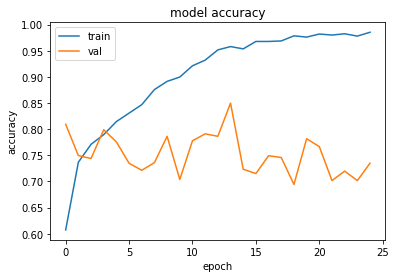

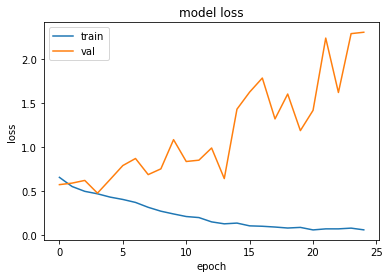

[[6924 2657]
 [ 219  548]]
F1 score: 0.2759315206445116
Precision: 0.17098283931357255
Recall: 0.7144719687092569
Accuracy: 0.7220718979512949
ROC AUC: 0.7185761367395569


In [71]:
nn_kfold(df_created_sin, balanced_batches=True)

Training data shape: (16807, 217)
Val data shape: (4202, 217)
Test data shape: (10348, 217)
Input shape: 216
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 216, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 215, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 215, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 214, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 214, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 213, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 51s 645ms/step - loss: 0.6944 - accuracy: 0.7057 - precision: 0.7057 - recall: 0.7057 - AUC: 0.7587 - val_loss: 0.9226 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1179
Epoch 2/20
79/79 [==============================] - 40s 501ms/step - loss: 0.5034 - accuracy: 0.7564 - precision: 0.7564 - recall: 0.7564 - AUC: 0.8407 - val_loss: 1.3059 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1096
Epoch 3/20
79/79 [==============================] - 41s 522ms/step - loss: 0.4498 - accuracy: 0.7887 - precision: 0.7887 - recall: 0.7887 - AUC: 0.8708 - val_loss: 0.9161 - val_accuracy: 0.1882 - val_precision: 0.1882 - val_recall: 0.1882 - val_AUC: 0.1592
Epoch 4/20
79/79 [==============================] - 43s 547ms/step - loss: 0.4084 - accuracy: 0.8031 - precision: 0.8031 - recall: 0.8031 - AUC: 0.8935 - val_loss: 0.8749 - val_accuracy: 0.3989 - val_precision: 0.3989 - val_recal

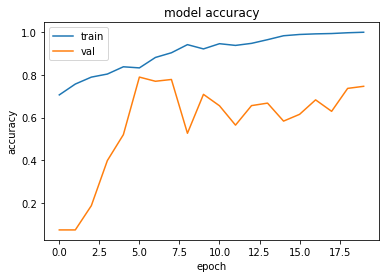

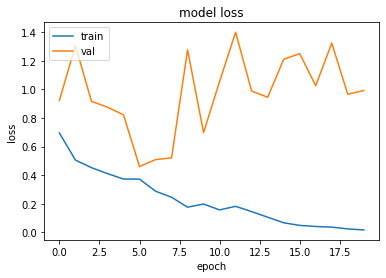

[[7205 2376]
 [ 244  523]]
F1 score: 0.28532460447354063
Precision: 0.18040703690927906
Recall: 0.681877444589309
Accuracy: 0.7468109779667569
ROC AUC: 0.7169433147171573


In [72]:
cnn(df_created_sin, balanced_batches=True)

## All created + squared continous columns

In [32]:
df_raw_mlp_ext.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_2,serum_zinc_2,serum_creatinine_2,lab_VitB12_2,bone_mineral_density_2,#_chronic_condition_2,hours_screen_2,combined_BP_2,people_per_rooms_2,diet_tot_VitB_2
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,12581.180396,4991.680256,9.059151,198305.571052,0.445877,1.0,4.0,47524.0,0.250000,90249.172225
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,17001.069514,6138.685741,9.059151,381841.413723,0.445877,4.0,4.0,39204.0,0.062500,663283.194084
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,15055.057823,5831.331824,9.059151,132595.480327,0.445877,1.0,1.0,39204.0,0.081633,83303.236129
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,15539.407404,6407.888282,9.059151,407710.932855,0.445877,4.0,64.0,30276.0,0.140625,95127.831184
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,13672.703062,5408.978846,9.059151,261492.485488,0.445877,0.0,36.0,28900.0,0.183673,288015.762241


Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_98 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_99 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_100 (Dropout)        (None, 100)               0         
__________

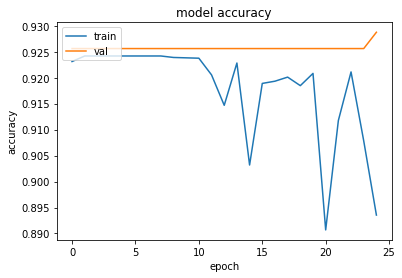

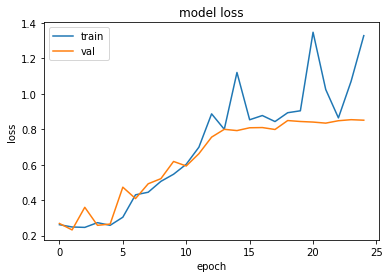

[[9521   60]
 [ 695   72]]
F1 score: 0.16017797552836485
Precision: 0.5454545454545454
Recall: 0.0938722294654498
Accuracy: 0.9270390413606494
ROC AUC: 0.5438049175716769


In [31]:
nn_kfold(df_raw_mlp_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 240, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 239, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 239, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 238, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 237, 64)           4160      
__________

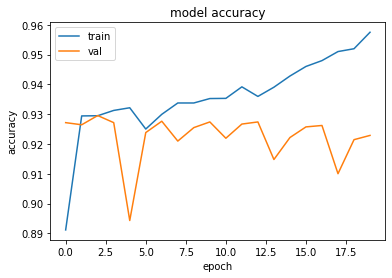

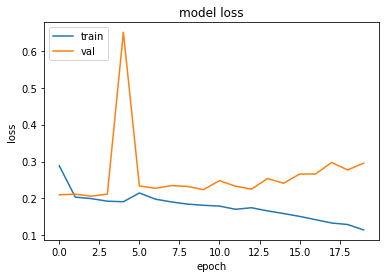

[[9335  246]
 [ 608  159]]
F1 score: 0.2713310580204778
Precision: 0.3925925925925926
Recall: 0.20730117340286833
Accuracy: 0.91747197526092
ROC AUC: 0.5908126783411377


In [32]:
cnn(df_raw_mlp_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_123 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_124 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_125 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 200us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.8786409382954268;  accuracy of 0.7428244948387146; precision of 0.7428244948387146; recall of 0.7428244948387146; AUC of 0.7876890897750854;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 206us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.9551996863536898;  accuracy of 0.6672854423522949; precision of 0.6672854423522949; recall of 0.6672854423522949; AUC of 0.6895846128463745;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 4s 616us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9067986491882987;  accuracy of 0.7064115405082703; precision of 0.7064115405082703; recall of 0.7064115405082703; AUC of 0.7336987853050232;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


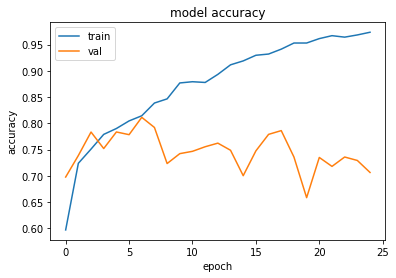

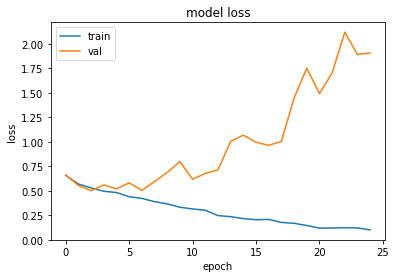

[[6603 2978]
 [ 206  561]]
F1 score: 0.26056665118439387
Precision: 0.15851935575021192
Recall: 0.7314211212516297
Accuracy: 0.6923076923076923
ROC AUC: 0.710298808199137


In [33]:
nn_kfold(df_raw_mlp_ext, balanced_batches=True)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 240, 1)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 239, 32)           96        
_________________________________________________________________
batch_normalization_56 (Batc (None, 239, 32)           128       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 238, 32)           2080      
_________________________________________________________________
batch_normalization_57 (Batc (None, 238, 32)           128       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 237, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 57s 725ms/step - loss: 0.7283 - accuracy: 0.7077 - precision: 0.7077 - recall: 0.7077 - AUC: 0.7655 - val_loss: 0.6438 - val_accuracy: 0.8379 - val_precision: 0.8379 - val_recall: 0.8379 - val_AUC: 0.8977
Epoch 2/20
79/79 [==============================] - 49s 617ms/step - loss: 0.5563 - accuracy: 0.7332 - precision: 0.7332 - recall: 0.7332 - AUC: 0.8184 - val_loss: 0.5657 - val_accuracy: 0.8287 - val_precision: 0.8287 - val_recall: 0.8287 - val_AUC: 0.8971
Epoch 3/20
79/79 [==============================] - 48s 609ms/step - loss: 0.4893 - accuracy: 0.7688 - precision: 0.7688 - recall: 0.7688 - AUC: 0.8505 - val_loss: 0.8364 - val_accuracy: 0.3858 - val_precision: 0.3858 - val_recall: 0.3858 - val_AUC: 0.3386
Epoch 4/20
79/79 [==============================] - 54s 688ms/step - loss: 0.4227 - accuracy: 0.8075 - precision: 0.8075 - recall: 0.8075 - AUC: 0.8848 - val_loss: 0.7149 - val_accuracy: 0.5816 - val_precision: 0.5816 - val_recal

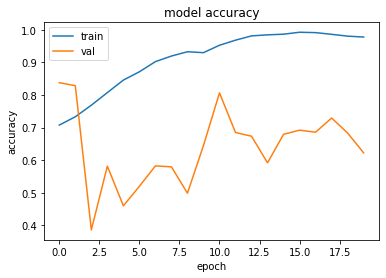

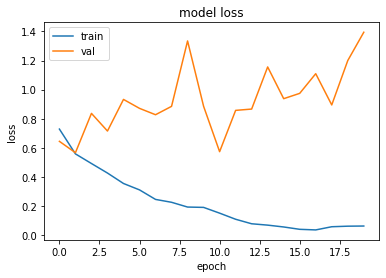

[[5876 3705]
 [ 175  592]]
F1 score: 0.23380726698262239
Precision: 0.13777053758436117
Recall: 0.771838331160365
Accuracy: 0.6250483185156552
ROC AUC: 0.6925677408854742


In [58]:
cnn(df_raw_mlp_ext, balanced_batches=True)

## squared + log(n)

In [33]:
df_add_log = df_raw_mlp_ext.copy()

cont, non_cont, cat_encode, = var_type(df_add_log)

# remove squared values from continous var list
og_cont = []
for i in range(len(cont)):
    if cont[i].endswith('_2') == False:
        og_cont.append(cont[i])

# log of all cont columns
for var in og_cont:
    df_add_log[str(var) + '_log'] = (df_add_log[var]-df_add_log[var].min()+1).transform(np.sqrt)


df_add_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,7.420638,6.344433,27.764101,20.695776,1.0,1.414214,1.732051,12.841418,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,8.560850,6.924577,27.764101,24.513938,1.0,1.732051,1.732051,12.037526,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,8.099324,6.779613,27.764101,18.631603,1.0,1.414214,1.414214,12.037526,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,8.219316,7.046225,27.764101,24.930352,1.0,1.732051,3.000000,10.995546,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,7.735007,6.568543,27.764101,22.234283,1.0,1.000000,2.645751,10.812124,1.162604,23.187734


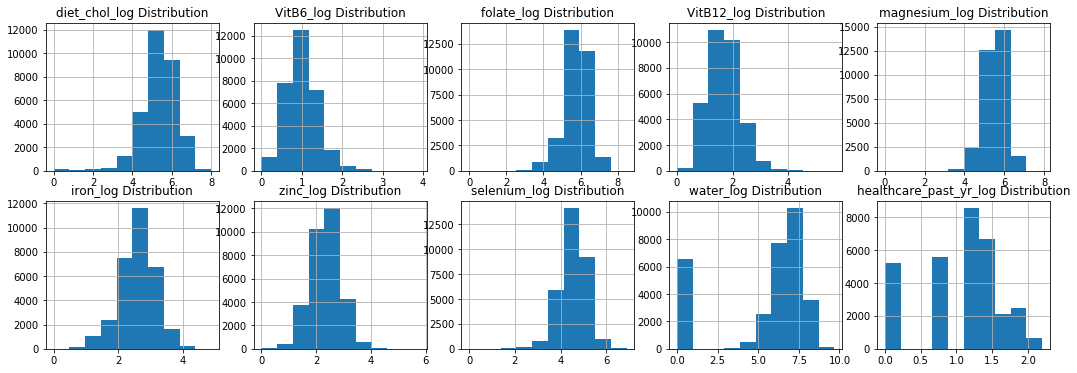

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,6))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    #fig.tight_layout()  # Improves appearance a bit.
    plt.show()

check = ['diet_chol_log',
 'VitB6_log',
 'folate_log',
 'VitB12_log',
 'magnesium_log',
 'iron_log',
 'zinc_log',
 'selenium_log',
 'water_log',
 'healthcare_past_yr_log']

draw_histograms(df_add_log, check, 2, 5)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               58800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

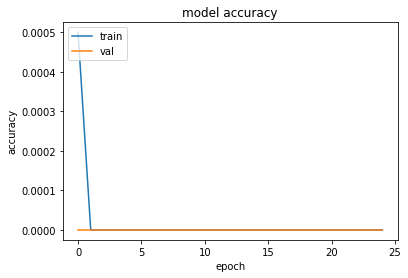

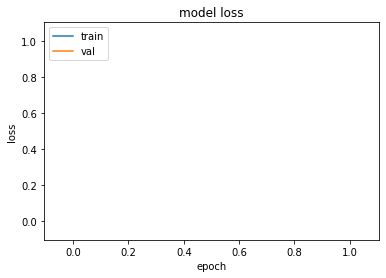

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
nn_kfold(df_add_log)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 293, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 292, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 292, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 291, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 291, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 290, 64)           4160      
__________

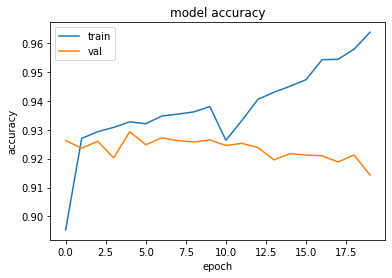

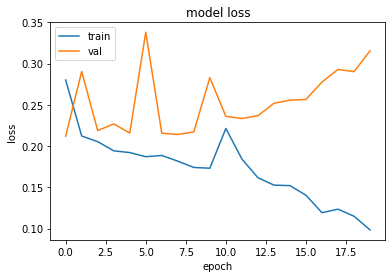

[[9234  347]
 [ 555  212]]
F1 score: 0.3197586726998492
Precision: 0.37924865831842575
Recall: 0.27640156453715775
Accuracy: 0.9128333977580209
ROC AUC: 0.6200920253538518


In [31]:
cnn(df_add_log)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               58800     
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 215us/step
------------------------------------------------------------------------
Score for fold 1: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 195us/step
------------------------------------------------------------------------
Score for fold 2: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 212us/step
------------------------------------------------------------------------
Score for fold 3: loss of nan;  accuracy of 0.0; precision of 0.0; recall of 0.0; AUC of 0.0;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


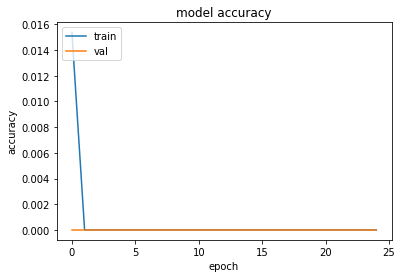

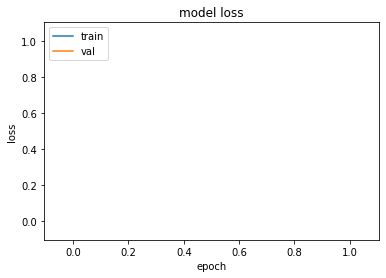

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
nn_kfold(df_add_log, balanced_batches=True)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 293, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 292, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 292, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 291, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 291, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 290, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 76s 967ms/step - loss: 0.7308 - accuracy: 0.7112 - precision: 0.7112 - recall: 0.7112 - AUC: 0.7612 - val_loss: 0.9175 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1127
Epoch 2/20
79/79 [==============================] - 72s 913ms/step - loss: 0.5249 - accuracy: 0.7548 - precision: 0.7548 - recall: 0.7548 - AUC: 0.8317 - val_loss: 0.9957 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.1160
Epoch 3/20
79/79 [==============================] - 66s 831ms/step - loss: 0.4656 - accuracy: 0.7883 - precision: 0.7883 - recall: 0.7883 - AUC: 0.8634 - val_loss: 0.7774 - val_accuracy: 0.3884 - val_precision: 0.3884 - val_recall: 0.3884 - val_AUC: 0.3690
Epoch 4/20
79/79 [==============================] - 59s 750ms/step - loss: 0.4346 - accuracy: 0.7987 - precision: 0.7987 - recall: 0.7987 - AUC: 0.8796 - val_loss: 1.0687 - val_accuracy: 0.3132 - val_precision: 0.3132 - val_recal

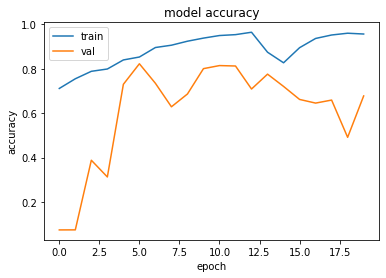

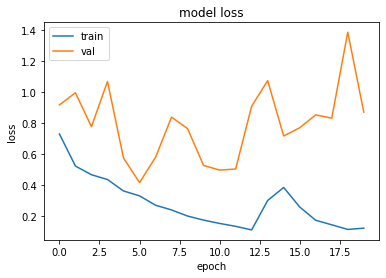

[[6466 3115]
 [ 207  560]]
F1 score: 0.2521386762719496
Precision: 0.1523809523809524
Recall: 0.7301173402868318
Accuracy: 0.6789717819868574
ROC AUC: 0.7024973508656788


In [32]:
cnn(df_add_log, balanced_batches=True)

## squared + log + square root

In [34]:
df_add_sqrt = df_add_log.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sqrt[str(var) + '_sqrt'] = (df_add_sqrt[var]-df_add_sqrt[var].min()+1).transform(np.sqrt)


df_add_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,7.420638,6.344433,27.764101,20.695776,1.0,1.414214,1.732051,12.841418,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,8.560850,6.924577,27.764101,24.513938,1.0,1.732051,1.732051,12.037526,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,8.099324,6.779613,27.764101,18.631603,1.0,1.414214,1.414214,12.037526,1.099450,17.018314
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,8.219316,7.046225,27.764101,24.930352,1.0,1.732051,3.000000,10.995546,1.139332,17.590566
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,7.735007,6.568543,27.764101,22.234283,1.0,1.000000,2.645751,10.812124,1.162604,23.187734


Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 200)               69400     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_103 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_104 (Dropout)        (None, 100)               0         
__________

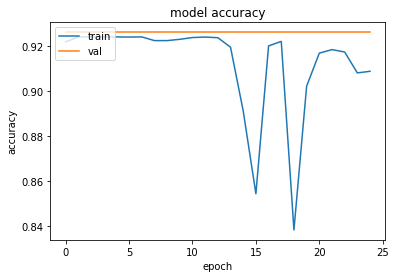

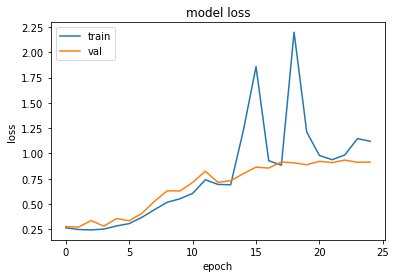

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
nn_kfold(df_add_sqrt)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 346, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 345, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 345, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 344, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 344, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 343, 64)           4160      
__________

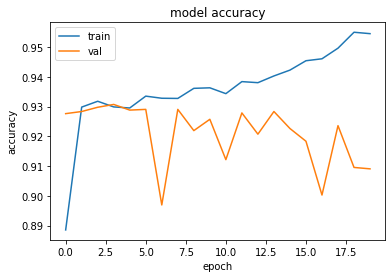

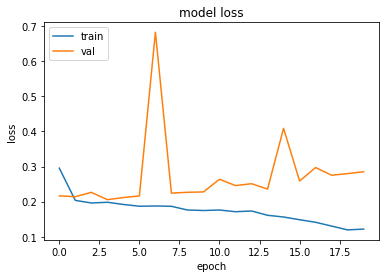

[[9138  443]
 [ 544  223]]
F1 score: 0.31123517096999304
Precision: 0.33483483483483484
Recall: 0.2907431551499348
Accuracy: 0.904619250096637
ROC AUC: 0.6222529052025636


In [39]:
cnn(df_add_sqrt)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 200)               69400     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_149 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_128 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_129 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 228us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.6768350459908683;  accuracy of 0.7238326668739319; precision of 0.7238326668739319; recall of 0.7238326668739319; AUC of 0.7820405960083008;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 229us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.28970024794421;  accuracy of 0.7759531736373901; precision of 0.7759531736373901; recall of 0.7759531736373901; AUC of 0.8244186043739319;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 230us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.0288013817922534;  accuracy of 0.8279308676719666; precision of 0.8279308676719666; recall of 0.8279308676719666; AUC of 0.8816477060317993;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


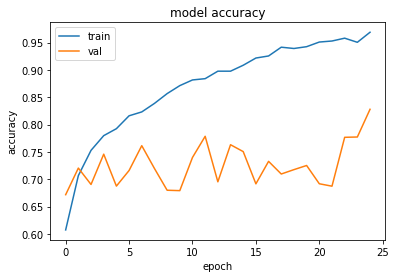

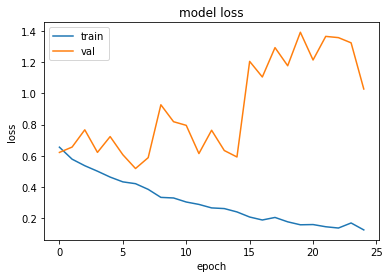

[[7950 1631]
 [ 329  438]]
F1 score: 0.30888575458392104
Precision: 0.21169647172547124
Recall: 0.5710560625814863
Accuracy: 0.8105914186316197
ROC AUC: 0.7004116551295908


In [40]:
nn_kfold(df_add_sqrt, balanced_batches=True)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 346, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 345, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 345, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 344, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 344, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 343, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 90s 1s/step - loss: 0.7147 - accuracy: 0.6922 - precision: 0.6922 - recall: 0.6922 - AUC: 0.7507 - val_loss: 0.6653 - val_accuracy: 0.7182 - val_precision: 0.7182 - val_recall: 0.7182 - val_AUC: 0.7856
Epoch 2/20
79/79 [==============================] - 97s 1s/step - loss: 0.5131 - accuracy: 0.7596 - precision: 0.7596 - recall: 0.7596 - AUC: 0.8323 - val_loss: 0.9495 - val_accuracy: 0.0766 - val_precision: 0.0766 - val_recall: 0.0766 - val_AUC: 0.1166
Epoch 3/20
79/79 [==============================] - 86s 1s/step - loss: 0.4744 - accuracy: 0.7776 - precision: 0.7776 - recall: 0.7776 - AUC: 0.8557 - val_loss: 0.4954 - val_accuracy: 0.8574 - val_precision: 0.8574 - val_recall: 0.8574 - val_AUC: 0.9277
Epoch 4/20
79/79 [==============================] - 79s 994ms/step - loss: 0.4563 - accuracy: 0.7863 - precision: 0.7863 - recall: 0.7863 - AUC: 0.8660 - val_loss: 0.6404 - val_accuracy: 0.6604 - val_precision: 0.6604 - val_recall: 0.6604

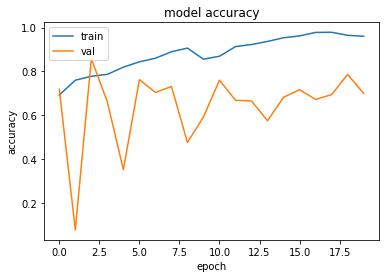

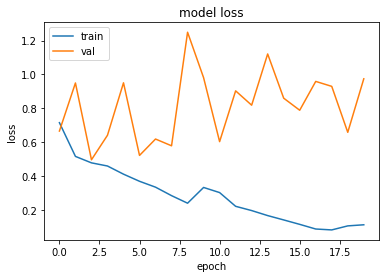

[[6622 2959]
 [ 227  540]]
F1 score: 0.25316455696202533
Precision: 0.15432980851671907
Recall: 0.7040417209908736
Accuracy: 0.6921144182450715
ROC AUC: 0.6976006538364241


In [41]:
cnn(df_add_sqrt, balanced_batches=True)

## + polynomial

In [35]:
df_add_poly = df_add_sqrt.copy()

# original continuous variables is og_cont

# 1+5x+8x2
for var in og_cont:
    df_add_poly[str(var) + '_poly'] = (1+(5*df_add_poly[var])+(8*np.power(df_add_poly[var],2)))


df_add_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_poly,serum_zinc_poly,serum_creatinine_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,101211.272474,40287.701172,88.522416,1.588672e+06,7.905711,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,136661.496861,49502.234753,88.522416,3.057822e+06,7.905711,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,121054.957850,47033.470382,88.522416,1.062586e+06,7.905711,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,124939.545031,51664.352692,88.522416,3.264881e+06,7.905711,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,109967.276169,43640.559569,88.522416,2.094498e+06,7.905711,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               80000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
___________

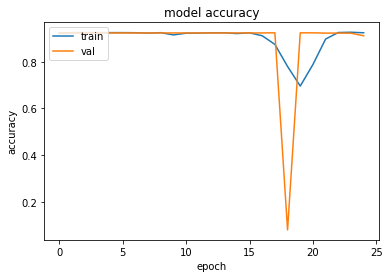

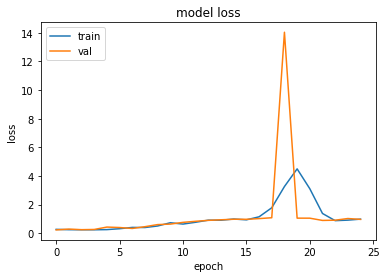

[[9267  314]
 [ 632  135]]
F1 score: 0.22203947368421054
Precision: 0.30066815144766146
Recall: 0.1760104302477184
Accuracy: 0.9085813683803634
ROC AUC: 0.5716186166477084


In [19]:
nn_kfold(df_add_poly)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 399, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 398, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 397, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 397, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 396, 64)           4160      
___________

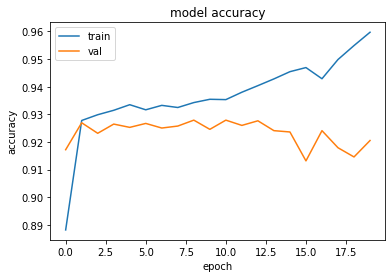

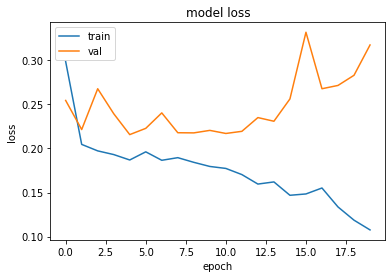

[[9328  253]
 [ 599  168]]
F1 score: 0.2828282828282828
Precision: 0.3990498812351544
Recall: 0.21903520208604954
Accuracy: 0.9176652493235408
ROC AUC: 0.5963143863472727


In [20]:
cnn(df_add_poly)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 200)               80000     
_________________________________________________________________
dropout_125 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_127 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 171us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.2949585592033488;  accuracy of 0.7262601852416992; precision of 0.7262601852416992; recall of 0.7262601852416992; AUC of 0.788705050945282;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 167us/step
------------------------------------------------------------------------
Score for fold 2: loss of 2.4309677074725977;  accuracy of 0.7015565037727356; precision of 0.7015565037727356; recall of 0.7015565037727356; AUC of 0.7125251293182373;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 240us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.4527374296788913;  accuracy of 0.7589604258537292; precision of 0.7589604258537292; recall of 0.7589604258537292; AUC of 0.7674531936645508;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


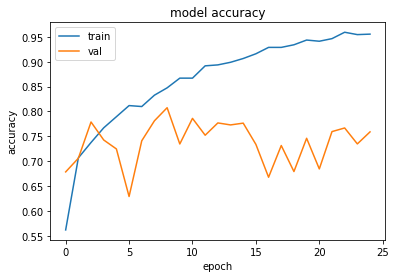

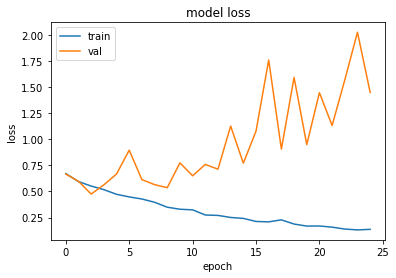

[[7215 2366]
 [ 247  520]]
F1 score: 0.2846975088967972
Precision: 0.18018018018018017
Recall: 0.6779661016949152
Accuracy: 0.7474874371859297
ROC AUC: 0.7155095094634685


In [36]:
nn_kfold(df_add_poly, balanced_batches=True)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 399, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 398, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 398, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 397, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 397, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 396, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 89s 1s/step - loss: 0.6907 - accuracy: 0.6946 - precision: 0.6946 - recall: 0.6946 - AUC: 0.7646 - val_loss: 0.6743 - val_accuracy: 0.6878 - val_precision: 0.6878 - val_recall: 0.6878 - val_AUC: 0.7236
Epoch 2/20
79/79 [==============================] - 76s 956ms/step - loss: 0.5183 - accuracy: 0.7520 - precision: 0.7520 - recall: 0.7520 - AUC: 0.8293 - val_loss: 0.8503 - val_accuracy: 0.1414 - val_precision: 0.1414 - val_recall: 0.1414 - val_AUC: 0.1283
Epoch 3/20
79/79 [==============================] - 78s 990ms/step - loss: 0.4515 - accuracy: 0.7911 - precision: 0.7911 - recall: 0.7911 - AUC: 0.8699 - val_loss: 0.6690 - val_accuracy: 0.6202 - val_precision: 0.6202 - val_recall: 0.6202 - val_AUC: 0.6483
Epoch 4/20
79/79 [==============================] - 98s 1s/step - loss: 0.4077 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - AUC: 0.8945 - val_loss: 0.6531 - val_accuracy: 0.6456 - val_precision: 0.6456 - val_recall: 0.6

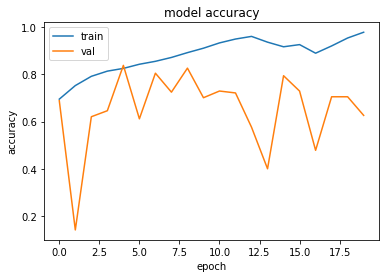

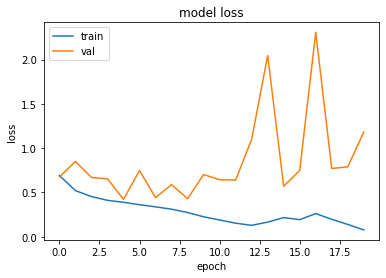

[[5989 3592]
 [ 177  590]]
F1 score: 0.23843200646595272
Precision: 0.1410808225729316
Recall: 0.7692307692307693
Accuracy: 0.6357750289911094
ROC AUC: 0.6971610479073165


In [37]:
cnn(df_add_poly, balanced_batches=True)

## + sin(n)

In [38]:
df_add_sin = df_add_poly.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sin[str(var) + '_sin'] = (df_add_sin[var]-df_add_sin[var].min()+1).transform(np.sin)


df_add_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sin,serum_zinc_sin,serum_creatinine_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,-0.996131,0.555430,-0.914834,0.871639,0.841471,0.909297,0.141120,0.999501,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,-0.858080,-0.735142,-0.914834,-0.776431,0.841471,0.141120,0.141120,0.379042,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,0.365707,0.917095,-0.914834,0.999956,0.841471,0.909297,0.909297,0.379042,0.935189,0.561730
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,-0.999917,-0.577935,-0.914834,-0.490693,0.841471,0.141120,0.412118,0.998785,0.963042,0.999822
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,-0.139616,-0.742327,-0.914834,-0.905821,0.841471,0.841471,0.656987,-0.615559,0.976083,-0.442744


Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_173 (Dense)            (None, 200)               90600     
_________________________________________________________________
dropout_150 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_174 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_152 (Dropout)        (None, 100)               0         
__________

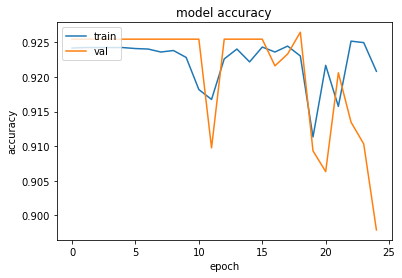

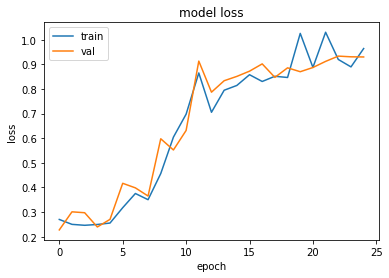

[[9137  444]
 [ 610  157]]
F1 score: 0.22953216374269006
Precision: 0.2612312811980033
Recall: 0.2046936114732725
Accuracy: 0.8981445689988403
ROC AUC: 0.5791759467448817


In [39]:
nn_kfold(df_add_sin)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 452, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 451, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 451, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 450, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 450, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 449, 64)           4160      
___________

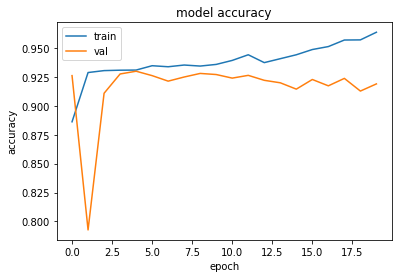

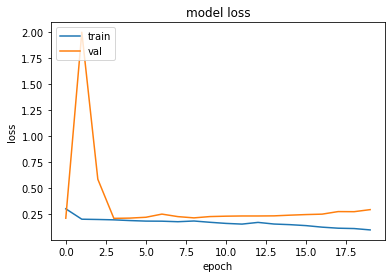

[[9360  221]
 [ 625  142]]
F1 score: 0.25132743362831855
Precision: 0.39118457300275483
Recall: 0.18513689700130379
Accuracy: 0.9182450715114032
ROC AUC: 0.5810352056241255


In [23]:
cnn(df_add_sin)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_200 (Dense)            (None, 200)               90600     
_________________________________________________________________
dropout_174 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_175 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_202 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_176 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 208us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.6181228785417463;  accuracy of 0.7409681677818298; precision of 0.7409681677818298; recall of 0.7409681677818298; AUC of 0.7880024313926697;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 329us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.7297813100132553;  accuracy of 0.6908468008041382; precision of 0.6908468008041382; recall of 0.6908468008041382; AUC of 0.7525848150253296;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 335us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.8476662320374386;  accuracy of 0.7352563142776489; precision of 0.7352563142776489; recall of 0.7352563142776489; AUC of 0.7742790579795837;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


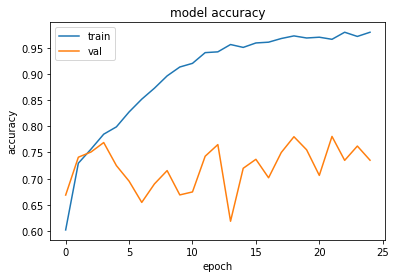

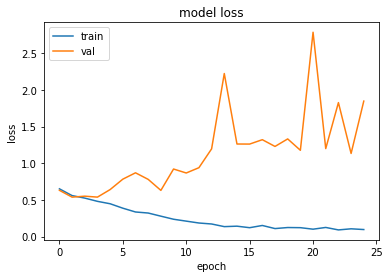

[[7007 2574]
 [ 251  516]]
F1 score: 0.26756546538760695
Precision: 0.1669902912621359
Recall: 0.6727509778357236
Accuracy: 0.7270003865481253
ROC AUC: 0.7020471307089067


In [40]:
nn_kfold(df_add_sin, balanced_batches=True)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 452, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 451, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 451, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 450, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 450, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 449, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/20
79/79 [==============================] - 94s 1s/step - loss: 0.7367 - accuracy: 0.6899 - precision: 0.6899 - recall: 0.6899 - AUC: 0.7461 - val_loss: 0.9763 - val_accuracy: 0.0750 - val_precision: 0.0750 - val_recall: 0.0750 - val_AUC: 0.1116
Epoch 2/20
79/79 [==============================] - 80s 1s/step - loss: 0.4927 - accuracy: 0.7716 - precision: 0.7716 - recall: 0.7716 - AUC: 0.8463 - val_loss: 1.2328 - val_accuracy: 0.0752 - val_precision: 0.0752 - val_recall: 0.0752 - val_AUC: 0.1137
Epoch 3/20
79/79 [==============================] - 80s 1s/step - loss: 0.4244 - accuracy: 0.8079 - precision: 0.8079 - recall: 0.8079 - AUC: 0.8852 - val_loss: 1.1090 - val_accuracy: 0.0797 - val_precision: 0.0797 - val_recall: 0.0797 - val_AUC: 0.1171
Epoch 4/20
79/79 [==============================] - 83s 1s/step - loss: 0.3746 - accuracy: 0.8315 - precision: 0.8315 - recall: 0.8315 - AUC: 0.9121 - val_loss: 0.9916 - val_accuracy: 0.2404 - val_precision: 0.2404 - val_recall: 0.2404 - 

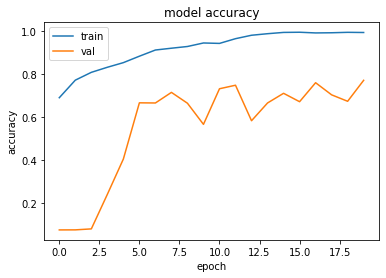

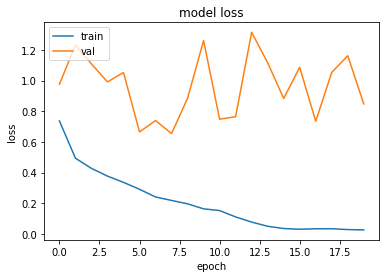

[[7475 2106]
 [ 286  481]]
F1 score: 0.28682170542635654
Precision: 0.18592964824120603
Recall: 0.6271186440677966
Accuracy: 0.7688442211055276
ROC AUC: 0.7036543016811168


In [41]:
cnn(df_add_sin, balanced_batches=True)